In [1]:
import sys
import os

current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.insert(0, parent_dir)

import pandas as pd 
import numpy as np 
import re
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset, Subset
from sklearn.model_selection import train_test_split
from directories import *
from VAE_models.VAE_model import *
from VAE_models.VAE_model_enhanced import *
from VAE_models.VAE_model_2 import *
from VAE_models.VAE_model_single import *
from training import *
from extras import *
from sklearn.decomposition import PCA
from collections import defaultdict

plt.style.use('ggplot')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
print(f"Current working directory: {current_dir}")
print(f"Parent directory: {parent_dir}")

Current working directory: /Users/anastasiiashcherbakova/git_projects/masters_project/genomes/2_new_loss
Parent directory: /Users/anastasiiashcherbakova/git_projects/masters_project/genomes


<a id='data_exploration'></a>
# 1) Data loading 

Loading essential genes and the dataset files 

In [3]:
essential_genes = pd.read_csv(PAPER_ESSENTIAL_GENES)

In [4]:
large_data = pd.read_csv(TEN_K_DATASET, index_col=[0], header=[0])

Turning all sample names uppercase for consistency

In [5]:
large_data.columns = large_data.columns.str.upper()

In [6]:
large_data

,41004_G02_CONTIGS_PACBIO,50884_F01_CONTIGS_PACBIO,AIAW00000000,AIBY00000000,AIFN00000000,NC_002655,NC_002695,NC_011353,NC_013008,NC_017906,...,ESC_PA2010AA_AS,ESC_PA2013AA_AS,ESC_PA2014AA_AS,ESC_PA2016AA_AS,ESC_PA2019AA_AS,ESC_PA2021AA_AS,ESC_PA2023AA_AS,ESC_PA2315AA_AS,ESC_RA2551AA_AS,ESC_RA2561AA_AS
Strain,,,,,,,,,,,,,,,,,,,,,
Lineage,1,1,1,1,1,1,1,1,1,1,...,51,51,51,51,51,51,51,51,51,51
group_5501,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
group_4783,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
group_4456,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
group_6055,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
group_2149_7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
group_2067_4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
group_2068_8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
large_data.sum(axis=1).sort_values()

Strain
group_569           1
group_4401_2        1
group_5102          1
group_5100_2        1
group_5099_3        1
                ...  
hldD             7512
group_4462_2     7512
grxC             7512
diaA             7512
Lineage         55565
Length: 55040, dtype: int64

Importing the phylogroup metadata 

In [8]:
data_without_lineage = large_data.drop(index=['Lineage'])
large_data_t = np.array(data_without_lineage.transpose())

print(f"Full dataset shape: {large_data_t.shape}")


Full dataset shape: (7512, 55039)


# 2) Data preprocessing

## 2.1) Dataset preprocessing 

In [9]:
phylogroup_data = pd.read_csv(TEN_K_DATASET_PHYLOGROUPS, index_col=[0], header=[0])

In [10]:
merged_df = pd.merge(data_without_lineage.transpose(), phylogroup_data, how='inner', left_index=True, right_on='ID')

In [11]:
data_array_t = np.array(merged_df.iloc[:, :-1])
phylogroups_array = np.array(merged_df.iloc[:, -1])

In [12]:
print("Checking dataset shapes")
print(f"Values array: {data_array_t.shape}")
print(f"Phylogroups array: {phylogroups_array.shape}")

Checking dataset shapes
Values array: (5953, 55039)
Phylogroups array: (5953,)


## 2.2) Conversing the dataset into splits and dataloaders

In [13]:
# Convert to PyTorch tensor
data_tensor = torch.tensor(data_array_t, dtype=torch.float32)

# Split into train and test sets
train_data, temp_data, train_labels, temp_labels = train_test_split(data_tensor, phylogroups_array, test_size=0.3, random_state=12345)
val_data, test_data, val_labels, test_labels = train_test_split(temp_data, temp_labels, test_size=0.3333, random_state=12345)
test_phylogroups = test_labels

# Set batch size
batch_size = 32

# TensorDataset
train_dataset = TensorDataset(train_data)
val_dataset = TensorDataset(val_data)
test_dataset = TensorDataset(test_data)

# Set laoders
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

In [14]:
print(f"Train data shape {train_data.shape}")
print(f"Test data shape {test_data.shape}")
print(f"Val data shape {val_data.shape}")

Train data shape torch.Size([4167, 55039])
Test data shape torch.Size([596, 55039])
Val data shape torch.Size([1190, 55039])


# 3) Essential genes manipulatioins

Creating an array of essential genes fromt the paper and flattening it 

In [15]:
essential_genes_array = np.array(essential_genes).flatten()

In [16]:
print(f"Total number of essential genes present in the paper: {len(essential_genes_array)}")

Total number of essential genes present in the paper: 358


Creating a gene mask for the essential arrays for more optimal counting of the essential arrays present in the samples 

In [17]:
all_genes = merged_df.columns

In [18]:
essential_genes_mask = np.isin(all_genes, essential_genes_array)

In [19]:
print(f"Total number of essential genes present in the dataset: {np.sum(essential_genes_mask)}")

Total number of essential genes present in the dataset: 316


Figuring out which genes are not present in the dataset

In [20]:
subset_not_in_essential_genes_mask = essential_genes[~np.isin(np.array(essential_genes), np.array(all_genes[essential_genes_mask]))]

Figuring out which genes are present in the dataset

In [21]:
subset_in_essential_genes_mask = essential_genes[np.isin(np.array(essential_genes), np.array(all_genes[essential_genes_mask]))]

Final results

In [22]:
absent_genes = np.array(subset_not_in_essential_genes_mask).flatten()

In [23]:
print(f"Number of genes not present in the dataset: {len(absent_genes)}")

Number of genes not present in the dataset: 42


In [24]:
present_genes = np.array(subset_in_essential_genes_mask).flatten()

In [25]:
print(f"Number of genes present in the dataset: {len(present_genes)}") 

Number of genes present in the dataset: 316


Seeing if the genes split into multiple parts in the dataset are the essential genes

In [26]:
matched_columns = []

for gene in absent_genes:
    pattern = re.compile(f"{gene}")
    matches = [col for col in merged_df.columns if pattern.match(col) and col not in present_genes]
    matched_columns.extend(matches)


divided_genes = np.array(matched_columns)
print(divided_genes)
print(len(divided_genes))


['msbA_2' 'msbA_1' 'msbA_3' 'fabG_2' 'fabG_1' 'fabG_3' 'fabG_1_1'
 'fabG_2_1' 'fabG_4' 'fabG_4_1' 'fabG_2_2' 'fabG2' 'fabG_2_3' 'lolD_2'
 'lolD_1' 'lolD_3' 'lolD_3_1' 'lolD_4' 'topA_3' 'topA_3_1' 'topA_2'
 'topA_1' 'topA_3_2' 'metG_2' 'metG_2_1' 'metG_2_2' 'fbaA_2' 'fbaA_1'
 'fbaA_3' 'fbaA_3_1' 'fbaA_1_1' 'higA_3' 'higA-1' 'higA1' 'higA1_1'
 'higA_1' 'higA_3_1' 'higA_1_1' 'higA_3_2' 'higA1_2' 'higA_2' 'higA1_3'
 'higA-2' 'higA_2_1' 'lptB_1' 'lptB_1_1' 'ssbA' 'ssb_1' 'ssb_1_1' 'ssb_2'
 'ssb_4' 'ssb_2_1' 'ssb_2_2' 'ssb_1_2' 'ssb_1_3' 'ssb_5' 'ssbA_1' 'lptG_1'
 'lptG_2' 'lptG_3' 'lptG_2_1' 'lptG_1_1' 'dnaC_3' 'dnaC_1' 'dnaC_2'
 'dnaC_1_1' 'dnaC_1_2' 'dnaC_1_3' 'dnaC_1_4' 'dnaC_1_5' 'dnaC_2_1'
 'dnaC_1_6' 'dnaC_2_2']
73


Manually creating the array of genes which is divided into chunks

In [27]:
divided_genes_prefixes = ['msbA', 'fabG', 'lolD', 'topA', 'metG', 'fbaA', 'higA', 'lptB', 'ssb',  'lptG', 'dnaC'] # 'higA-1', 'higA1','higA-2', 'ssbA' dont count 

In [28]:
not_present = np.array(list(set(absent_genes) - set(divided_genes_prefixes)))

In [29]:
print(f"Genes which are still not present in the dataset after prefix extraction: {not_present}")
print(f"Total number: {len(not_present)}")

Genes which are still not present in the dataset after prefix extraction: ['ymfE' 'dicA' 'ygeG' 'ydcD' 'yedN' 'ycaR' 'pheM' 'trpL' 'yobI' 'cydC'
 'ispU' 'yihA' 'racR' 'ykfM' 'ydaE' 'cydX' 'yciS' 'ygeN' 'ydhL' 'ydaS'
 'yddL' 'ygeF' 'ymiB' 'yncH' 'yjbS' 'cohE' 'yffS' 'ynbG' 'dfp' 'yqeL'
 'ttcC']
Total number: 31


Creating a new array of the genes (both sigle name and didived) present in the dataset 

In [30]:
combined_array = np.concatenate((present_genes, divided_genes))

In [31]:
print(f"Total umber of genes that count as essential in the dataset: {len(combined_array)}")

Total umber of genes that count as essential in the dataset: 389


Creating a new gene mask including the divided essential genes 

In [32]:
essential_genes_mask = np.isin(all_genes, combined_array)

In [33]:
essential_genes_df = merged_df.loc[:, essential_genes_mask].copy()

In [34]:
essential_genes_df

,higA_3,topA_3,higA-1,dnaC_3,higA1,ssbA,fbaA_2,holB,metG_2,relB,...,higA-2,lptG_2_1,ssb_1_3,topA_3_2,ssb_5,ssbA_1,metG_2_2,dnaC_2_2,higA_2_1,lptG_1_1
ID,,,,,,,,,,,,,,,,,,,,,
AIAW00000000,0,0,0,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
AIBY00000000,0,0,0,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
AIFN00000000,0,0,0,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
NC_002655,0,0,0,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
NC_002695,0,0,0,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ESC_PA2021AA_AS,0,0,0,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
ESC_PA2023AA_AS,0,0,0,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
ESC_PA2315AA_AS,0,0,0,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
gene_sums = essential_genes_df.sum()
zero_sum_genes = gene_sums[gene_sums == 0].index.tolist()
print(f"Genes that are not present (overall 0 in all samples): {zero_sum_genes}")

Genes that are not present (overall 0 in all samples): ['dnaC_1_3', 'ssb_1_2', 'lptG_2_1']


Dataframe of just absent essential genes (including the ones that are split up)

In [36]:
absent_essential_genes_df = pd.DataFrame()

for prefix in absent_genes:
    cols_to_merge = essential_genes_df.filter(regex=f'^{prefix}')
    absent_essential_genes_df[prefix] = (cols_to_merge.sum(axis=1) > 0).astype(int)

In [37]:
absent_essential_genes_df

,ispU,ykfM,cydX,cydC,msbA,ycaR,fabG,lolD,ymfE,cohE,...,ygeN,fbaA,higA,lptB,dfp,yihA,yjbS,ssb,lptG,dnaC
ID,,,,,,,,,,,,,,,,,,,,,
AIAW00000000,0,0,0,0,1,0,1,1,0,0,...,0,1,1,1,0,0,0,1,1,1
AIBY00000000,0,0,0,0,1,0,1,1,0,0,...,0,1,1,1,0,0,0,1,1,1
AIFN00000000,0,0,0,0,1,0,1,1,0,0,...,0,1,1,1,0,0,0,1,1,1
NC_002655,0,0,0,0,1,0,1,1,0,0,...,0,1,1,1,0,0,0,1,1,1
NC_002695,0,0,0,0,1,0,1,1,0,0,...,0,1,1,1,0,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ESC_PA2021AA_AS,0,0,0,0,1,0,1,1,0,0,...,0,1,1,1,0,0,0,1,1,1
ESC_PA2023AA_AS,0,0,0,0,1,0,1,1,0,0,...,0,1,1,1,0,0,0,1,1,1
ESC_PA2315AA_AS,0,0,0,0,1,0,1,1,0,0,...,0,1,1,1,0,0,0,1,1,1


Datafarme of the genes that are divided into chunks

In [38]:
intermediate = essential_genes_df.drop(columns=divided_genes)

In [39]:
intermediate

,holB,relB,coaE,aceF,can,hemL,erpA,dapD,map,rpsB,...,holA,lptE,leuS,lnt,ybeY,glnS,fldA,hemB,iraM,lpd
ID,,,,,,,,,,,,,,,,,,,,,
AIAW00000000,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,0,0
AIBY00000000,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,0,0
AIFN00000000,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,0,0
NC_002655,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,0,0
NC_002695,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ESC_PA2021AA_AS,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,0,0
ESC_PA2023AA_AS,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,0,0
ESC_PA2315AA_AS,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,0,0


Adding the absent essential genes that are present in the dataframe to the overall dataframe of the genes presemt in the datatframe

In [40]:
row_sums = absent_essential_genes_df.sum(axis=0)
columns_to_add = absent_essential_genes_df.columns[row_sums != 0]

In [41]:
columns_to_add

Index(['msbA', 'fabG', 'lolD', 'topA', 'metG', 'fbaA', 'higA', 'lptB', 'ssb',
       'lptG', 'dnaC'],
      dtype='object')

In [42]:
absent_essential_genes_df[columns_to_add]

,msbA,fabG,lolD,topA,metG,fbaA,higA,lptB,ssb,lptG,dnaC
ID,,,,,,,,,,,
AIAW00000000,1,1,1,1,1,1,1,1,1,1,1
AIBY00000000,1,1,1,1,1,1,1,1,1,1,1
AIFN00000000,1,1,1,1,1,1,1,1,1,1,1
NC_002655,1,1,1,1,1,1,1,1,1,1,1
NC_002695,1,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
ESC_PA2021AA_AS,1,1,1,1,1,1,1,1,1,1,1
ESC_PA2023AA_AS,1,1,1,1,1,1,1,1,1,1,1
ESC_PA2315AA_AS,1,1,1,1,1,1,1,1,1,1,1


In [43]:
absent_essential_genes_df[columns_to_add].columns

Index(['msbA', 'fabG', 'lolD', 'topA', 'metG', 'fbaA', 'higA', 'lptB', 'ssb',
       'lptG', 'dnaC'],
      dtype='object')

Adding these selected columns to the original DataFrame

In [44]:
for col in absent_essential_genes_df[columns_to_add].columns:
    intermediate[col] = absent_essential_genes_df[col]

Intermediate dataframe to plot the frequency of the present in the dataframe genes:

In [45]:
intermediate

,holB,relB,coaE,aceF,can,hemL,erpA,dapD,map,rpsB,...,fabG,lolD,topA,metG,fbaA,higA,lptB,ssb,lptG,dnaC
ID,,,,,,,,,,,,,,,,,,,,,
AIAW00000000,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
AIBY00000000,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
AIFN00000000,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
NC_002655,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
NC_002695,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ESC_PA2021AA_AS,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
ESC_PA2023AA_AS,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
ESC_PA2315AA_AS,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [46]:
intermediate.sum(axis=0)

holB    5953
relB      30
coaE    5953
aceF    5953
can     5953
        ... 
higA    5924
lptB    5953
ssb     5941
lptG    5953
dnaC    5949
Length: 327, dtype: int64

In [47]:
np.save('/Users/anastasiiashcherbakova/git_projects/masters_project/data/essential_gene_in_ds.npy', intermediate.columns.to_list())

In [48]:
EG_distribution = intermediate.sum(axis=1)
mean = np.mean(EG_distribution)
median = np.median(EG_distribution)
min_value = np.min(EG_distribution)
max_value = np.max(EG_distribution)

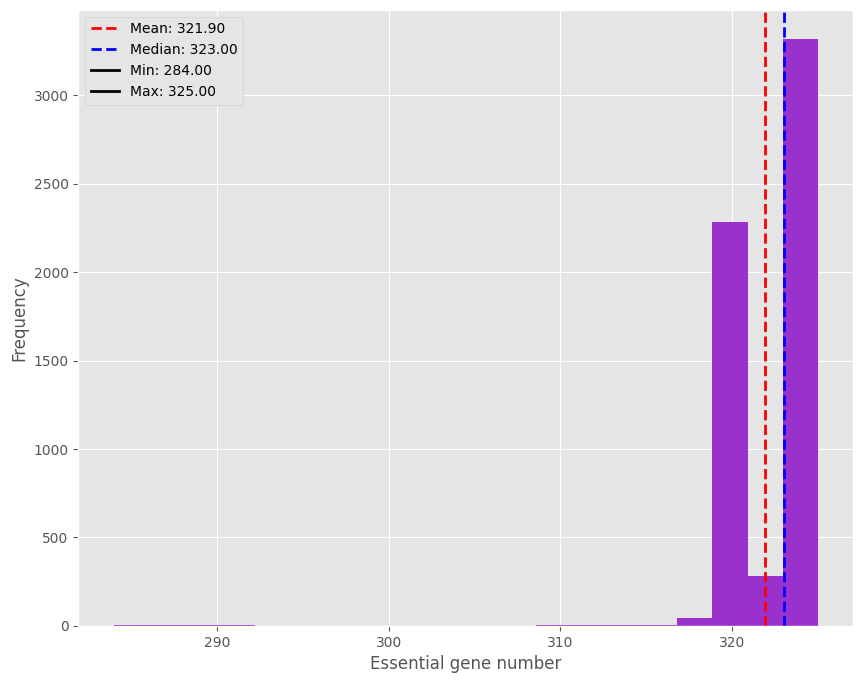

In [49]:
plt.figure(figsize=(10,8))
plt.hist(EG_distribution, color='darkorchid', bins=20)
plt.xlabel('Essential gene number')
plt.ylabel('Frequency')
plt.axvline(mean, color='r', linestyle='dashed', linewidth=2, label=f'Mean: {mean:.2f}')
plt.axvline(median, color='b', linestyle='dashed', linewidth=2, label=f'Median: {median:.2f}')
dummy_min = plt.Line2D([], [], color='black',  linewidth=2, label=f'Min: {min_value:.2f}')
dummy_max = plt.Line2D([], [], color='black', linewidth=2, label=f'Max: {max_value:.2f}')

handles = [plt.Line2D([], [], color='r', linestyle='dashed', linewidth=2, label=f'Mean: {mean:.2f}'),
        plt.Line2D([], [], color='b', linestyle='dashed', linewidth=2, label=f'Median: {median:.2f}'),
        dummy_min, dummy_max]
plt.legend(handles=handles)
plt.savefig("/Users/anastasiiashcherbakova/git_projects/masters_project/figures/EG_number.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [50]:
EG_distribution = intermediate.sum(axis=1) / intermediate.sum(axis=1).max()
mean = np.mean(EG_distribution)
median = np.median(EG_distribution)
min_value = np.min(EG_distribution)
max_value = np.max(EG_distribution)

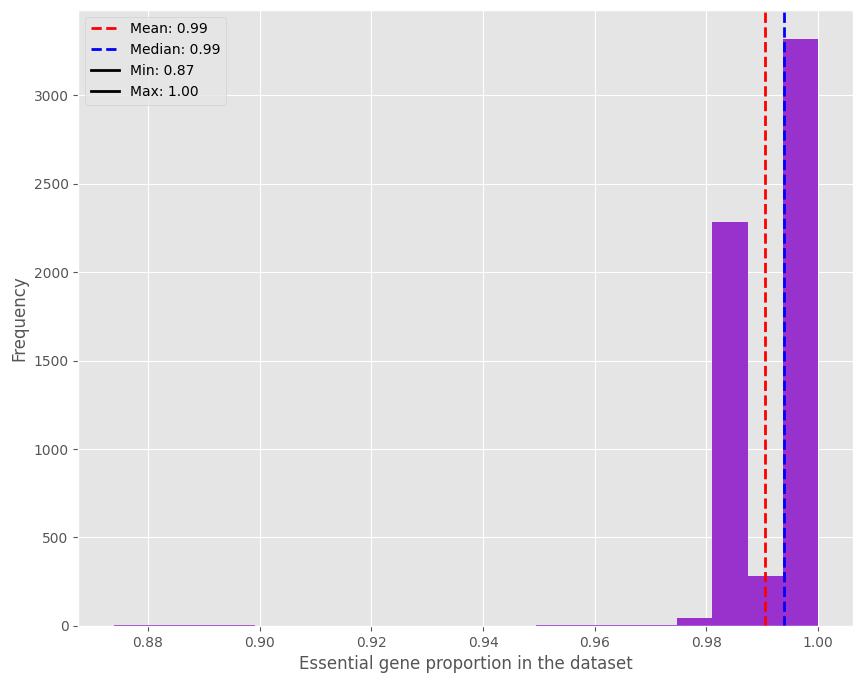

In [51]:
plt.figure(figsize=(10,8))
plt.hist(EG_distribution, color='darkorchid', bins=20)
plt.xlabel('Essential gene proportion in the dataset')
plt.ylabel('Frequency')
plt.axvline(mean, color='r', linestyle='dashed', linewidth=2, label=f'Mean: {mean:.2f}')
plt.axvline(median, color='b', linestyle='dashed', linewidth=2, label=f'Median: {median:.2f}')
dummy_min = plt.Line2D([], [], color='black',  linewidth=2, label=f'Min: {min_value:.2f}')
dummy_max = plt.Line2D([], [], color='black', linewidth=2, label=f'Max: {max_value:.2f}')

handles = [plt.Line2D([], [], color='r', linestyle='dashed', linewidth=2, label=f'Mean: {mean:.2f}'),
        plt.Line2D([], [], color='b', linestyle='dashed', linewidth=2, label=f'Median: {median:.2f}'),
        dummy_min, dummy_max]
plt.legend(handles=handles)
plt.savefig("/Users/anastasiiashcherbakova/git_projects/masters_project/figures/EG_number_proportion.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [52]:
datatset_EG = list(intermediate.columns)

In [53]:
def extract_prefix(gene):
    match = re.match(r"([a-zA-Z0-9]+)", gene)
    if match:
        return match.group(1)
    return gene

# Group gene positions by their prefix
groups_of_gene_positions = defaultdict(list)
for idx, gene in enumerate(all_genes):
    prefix = extract_prefix(gene)
    groups_of_gene_positions[prefix].append(idx)

# Convert defaultdict to a regular dict
groups_of_gene_positions = dict(groups_of_gene_positions)

# Print the dictionary to verify
for prefix, positions in groups_of_gene_positions.items():
    print(f"{prefix}: {positions}")

group: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 42, 43, 44, 45, 46, 47, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 86, 87, 88, 89, 90, 91, 92, 93, 94, 97, 98, 99, 100, 101, 104, 106, 107, 108, 109, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 134, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 155, 156, 157, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 209, 210, 211, 212, 213, 214, 215, 217, 218, 219, 220, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 238, 239, 240, 

Precompute essential gene positions

In [54]:
essential_gene_positions = {}
for gene in essential_genes_array:
    if gene in groups_of_gene_positions.keys():
        essential_gene_positions[gene] = groups_of_gene_positions[gene]

In [55]:
essential_gene_positions

{'rpsT': [15341],
 'ribF': [15340],
 'ileS': [15339],
 'lspA': [15338, 36962, 42383],
 'ispH': [15336],
 'dapB': [15334, 40591],
 'folA': [1511, 15316],
 'lptD': [15308],
 'ftsL': [15283],
 'ftsI': [15282, 40806],
 'murE': [15281, 40807],
 'murF': [15280, 33264, 33265, 40809],
 'mraY': [15279, 40810],
 'murD': [15278, 33262, 33263],
 'ftsW': [15277],
 'murG': [15276],
 'murC': [15275],
 'ftsQ': [15273],
 'ftsA': [15272],
 'ftsZ': [15271],
 'lpxC': [15270],
 'secA': [15268],
 'coaE': [11933],
 'aceF': [11944],
 'lpd': [19570],
 'can': [11956],
 'hemL': [11985, 42003],
 'erpA': [11987, 37359],
 'dapD': [11996],
 'map': [11998, 39912],
 'rpsB': [11999],
 'tsf': [12000, 48412],
 'pyrH': [12001],
 'frr': [12002],
 'dxr': [12003],
 'cdsA': [12006, 12100, 29339, 30377, 34707],
 'bamA': [12008],
 'lpxD': [12010, 46997],
 'fabZ': [12011],
 'lpxA': [12012],
 'lpxB': [12013],
 'dnaE': [9123, 12015, 18059, 23498, 31303, 41020, 50504],
 'accA': [12016, 40738],
 'tilS': [12019, 40737],
 'proS': [164

Calculating the abundance of essential genes in the dataset 

In [56]:
essential_gene_abundance = pd.Series(0, index=essential_genes_array)

column_names = merged_df.columns

for gene, positions in essential_gene_positions.items():
    if len(positions) == 1:
        pos = positions[0]
        column_name = column_names[pos]
        essential_gene_abundance[gene] = merged_df[column_name].sum()
    else:
        column_subset = [column_names[pos] for pos in positions]
        essential_gene_abundance[gene] = merged_df[column_subset].sum(axis=1).sum()


In [57]:
gene_sums = intermediate.sum()
mean = np.mean(gene_sums)
median = np.median(gene_sums)
min_value = np.min(gene_sums)
max_value = np.max(gene_sums)

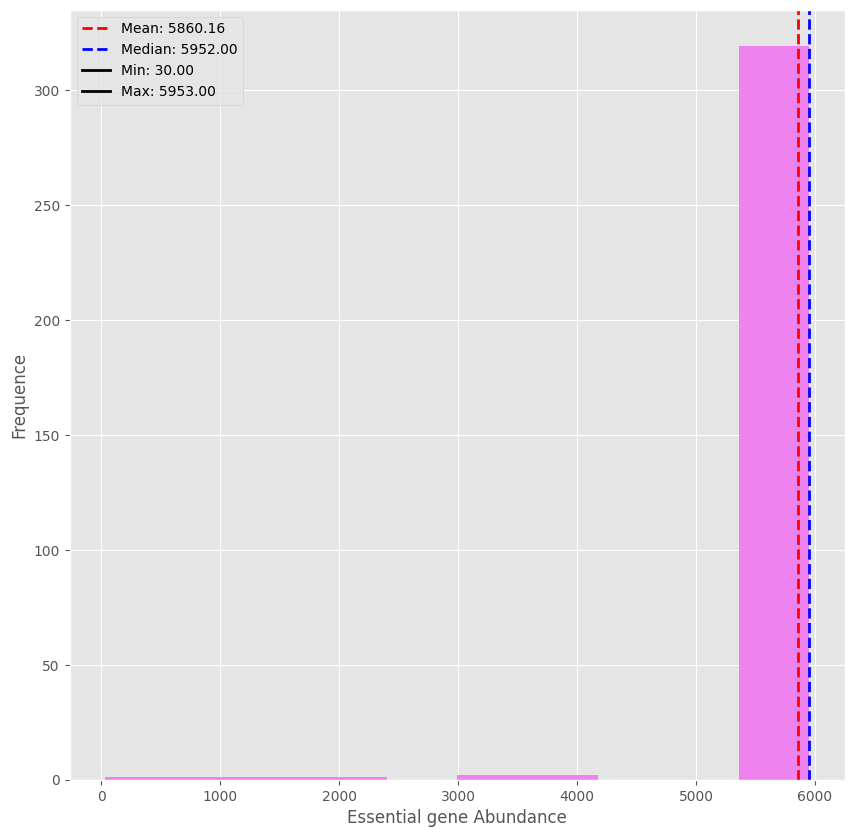

In [58]:
plt.figure(figsize=(10, 10))
plt.hist(gene_sums, color='violet')
plt.xlabel('Essential gene Abundance')
plt.ylabel('Frequence')
plt.axvline(mean, color='r', linestyle='dashed', linewidth=2, label=f'Mean: {mean:.2f}')
plt.axvline(median, color='b', linestyle='dashed', linewidth=2, label=f'Median: {median:.2f}')
dummy_min = plt.Line2D([], [], color='black',  linewidth=2, label=f'Min: {min_value:.2f}')
dummy_max = plt.Line2D([], [], color='black', linewidth=2, label=f'Max: {max_value:.2f}')

handles = [plt.Line2D([], [], color='r', linestyle='dashed', linewidth=2, label=f'Mean: {mean:.2f}'),
        plt.Line2D([], [], color='b', linestyle='dashed', linewidth=2, label=f'Median: {median:.2f}'),
        dummy_min, dummy_max]
plt.legend(handles=handles)
plt.savefig("/Users/anastasiiashcherbakova/git_projects/masters_project/figures/essential_genes_frequency.pdf", format="pdf", bbox_inches="tight")

In [59]:
print(f"Minimal gene abundance: {gene_sums.min()}")

Minimal gene abundance: 30


# 4) Training of full dataset

## 4.1) Full dataset (base model)

In [60]:
# Load trained model 
input_dim = 55039
hidden_dim = 1024
latent_dim = 32
path_to_model = '/Users/anastasiiashcherbakova/Desktop/2_bigdataset/2_bigdataset/8_final_dataset_new_params/saved_KL_annealing_VAE_BD_100.pt'

model, binary_generated_samples = load_model(input_dim, hidden_dim, latent_dim, path_to_model)

Generated samples (binary):
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Generated samples (sigmoid function output):
 [[1.74862426e-02 5.93947014e-04 1.03584003e-04 ... 2.41412345e-05
  2.73712740e-05 7.42397388e-05]
 [3.86628584e-04 9.09513619e-05 2.83283470e-07 ... 8.64533922e-06
  9.58367400e-06 2.40614772e-05]
 [2.46385025e-05 4.80261271e-08 1.20342865e-08 ... 1.09561915e-06
  1.09578741e-06 2.06897494e-06]
 ...
 [6.04911149e-02 2.86329479e-04 8.73529231e-08 ... 1.12359555e-06
  1.10122346e-06 6.39087875e-06]
 [1.60035084e-03 1.73724511e-05 2.40268747e-07 ... 8.12948485e-07
  9.14579630e-07 2.87650369e-06]
 [1.48187904e-03 1.20960060e-03 5.44946670e-05 ... 1.88017075e-05
  2.25054027e-05 3.16743681e-05]]


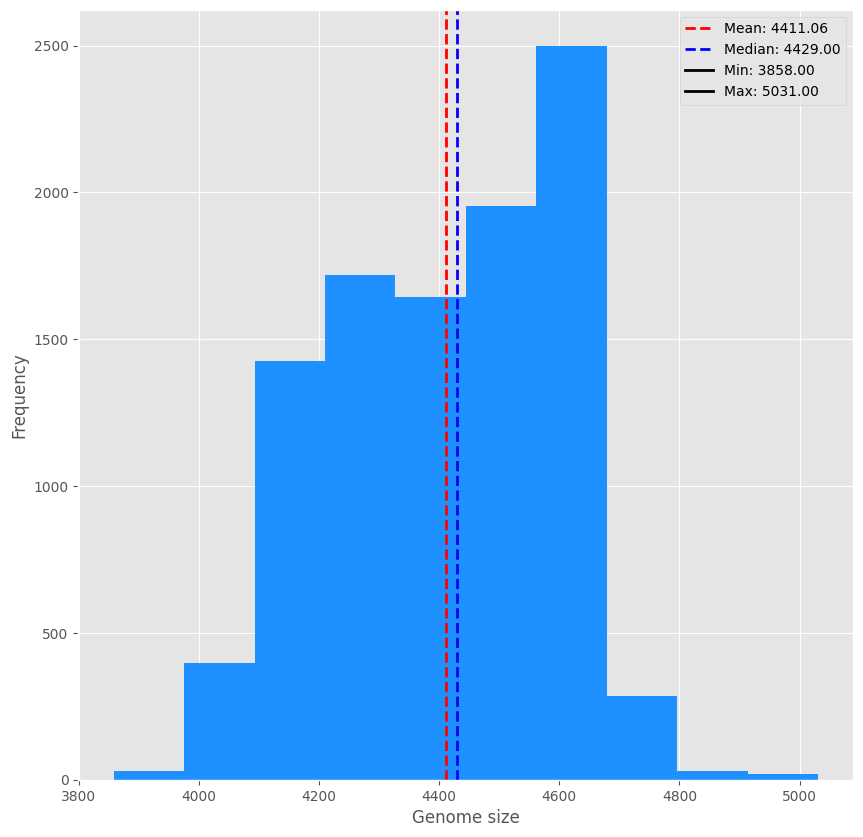

In [61]:
figure_name = "/Users/anastasiiashcherbakova/git_projects/masters_project/figures/sampling_10000_genome_size_distribution_8_final_dataset_new_params.pdf"
plot_color = "dodgerblue"

plot_samples_distribution(binary_generated_samples, figure_name, plot_color)

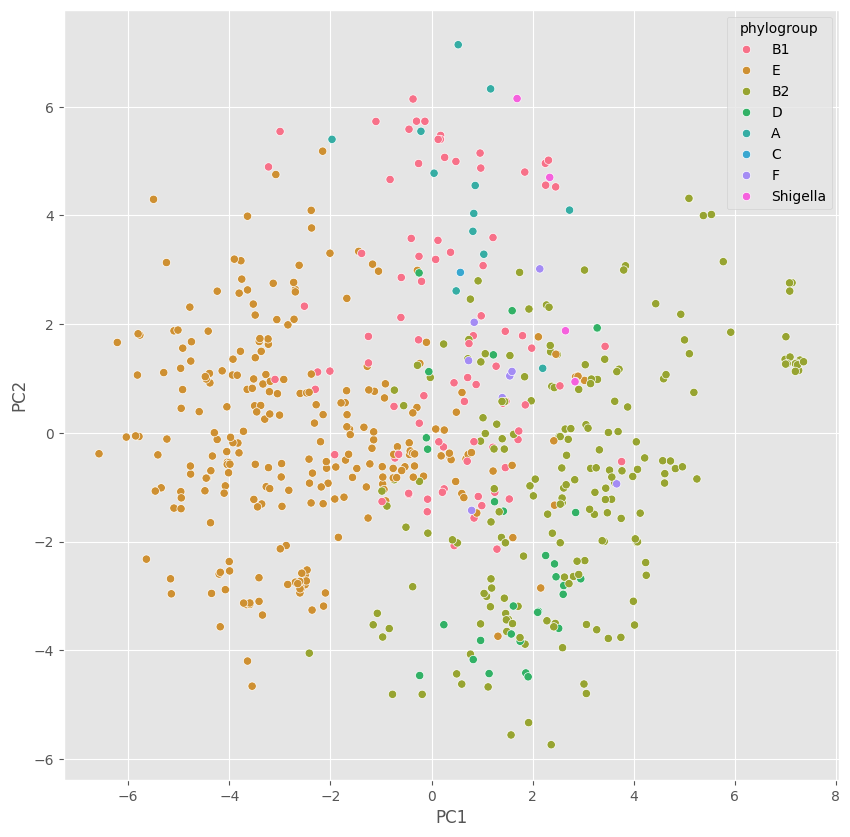

In [62]:
latents = get_latent_variables(model, test_loader, device)
pca = PCA(n_components=2)
data_pca = pca.fit_transform(latents)
df_pca = pd.DataFrame(data_pca, columns=['PC1', 'PC2'])
df_pca['phylogroup'] = test_phylogroups

plt.figure(figsize=(10, 10))
sns.scatterplot(x='PC1', y='PC2', hue = df_pca['phylogroup'], data=df_pca)
plt.savefig("/Users/anastasiiashcherbakova/git_projects/masters_project/figures/pca_latent_space_visualisation_8_final_dataset_new_params.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [63]:
essential_genes_count_per_sample = count_essential_genes(binary_generated_samples, essential_gene_positions)

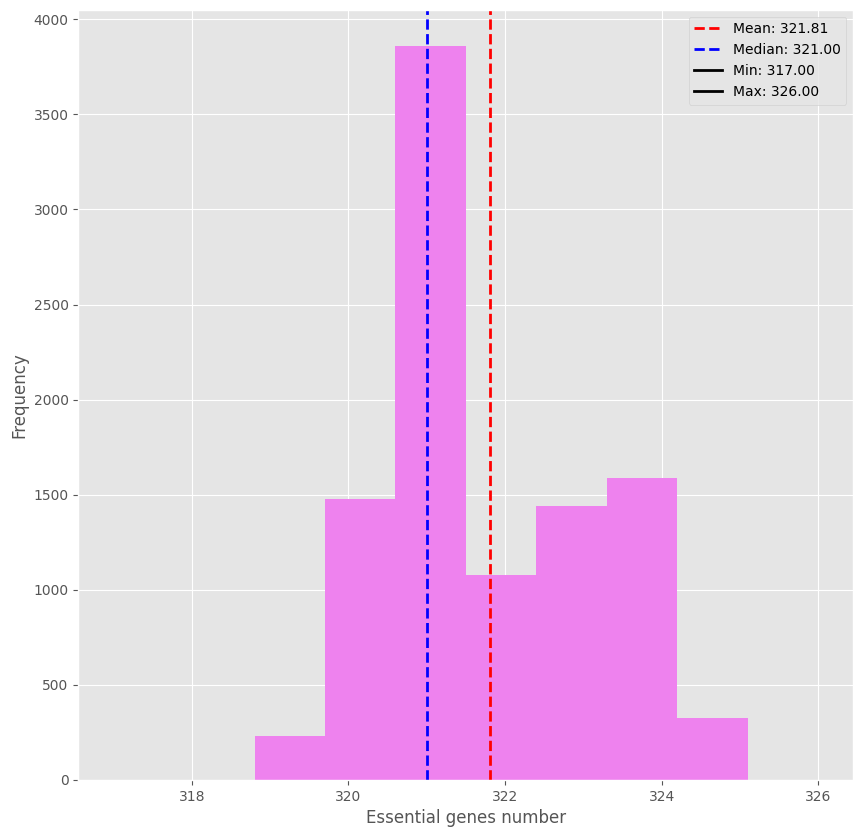

In [64]:
plot_color = "violet"
figure_name ="/Users/anastasiiashcherbakova/git_projects/masters_project/figures/essential_genes_8_final_dataset_new_params.pdf"

plot_essential_genes_distribution(essential_genes_count_per_sample, figure_name, plot_color)

----------

## 4.1) Full dataset (enhanced model with fropout layers in decoder)

In [65]:
# Load trained model 
input_dim = 55039
hidden_dim = 1024
latent_dim = 32
path_to_model = "/Users/anastasiiashcherbakova/Desktop/2_bigdataset/2_bigdataset/9_final_dataset_enhanced/saved_KL_annealing_VAE_BD_100.pt"

model, binary_generated_samples = load_model_enhanced(input_dim, hidden_dim, latent_dim, path_to_model)

Generated samples (binary):
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Generated samples (sigmoid function output):
 [[3.62287983e-02 3.32951383e-03 2.10464641e-04 ... 2.28652905e-04
  2.59868859e-04 2.56472093e-04]
 [1.00270219e-01 2.54944852e-03 4.94781462e-03 ... 1.16311770e-03
  1.23488554e-03 6.78124256e-04]
 [2.79567689e-02 2.19477993e-03 1.79135372e-04 ... 9.86386294e-06
  1.09899847e-05 1.08908253e-05]
 ...
 [9.74154249e-02 2.87286966e-05 8.60096407e-06 ... 1.99930335e-04
  2.34010397e-04 1.21922400e-04]
 [1.94457278e-03 8.99588395e-06 6.20148276e-05 ... 5.66445633e-05
  5.86852657e-05 1.03435064e-04]
 [1.44895643e-01 6.75942050e-04 6.51235343e-04 ... 2.17610403e-04
  2.32873717e-04 1.19852484e-04]]


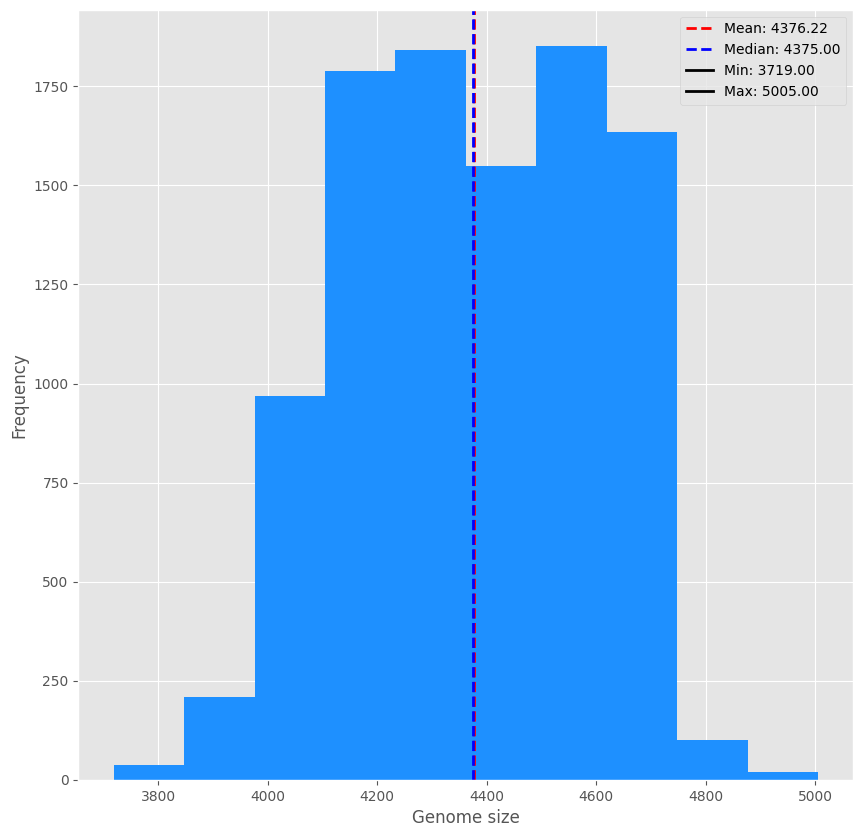

In [66]:
figure_name = "/Users/anastasiiashcherbakova/git_projects/masters_project/figures/sampling_10000_genome_size_distribution_9_final_dataset_enhanced.pdf"
plot_color = "dodgerblue"

plot_samples_distribution(binary_generated_samples, figure_name, plot_color)

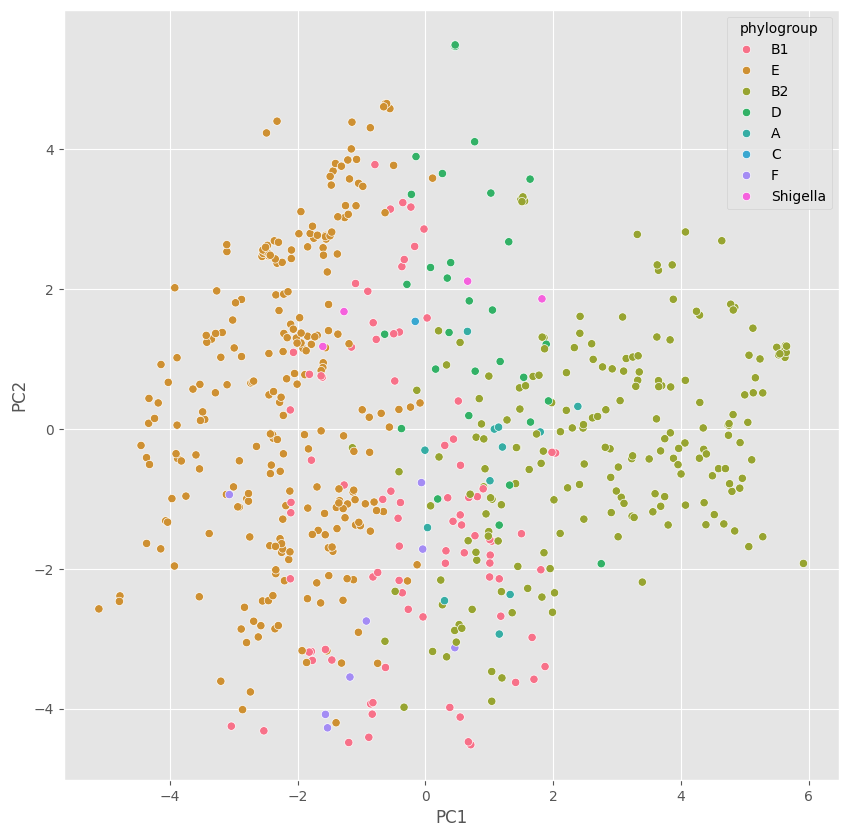

In [67]:
latents = get_latent_variables(model, test_loader, device)
pca = PCA(n_components=2)
data_pca = pca.fit_transform(latents)
df_pca = pd.DataFrame(data_pca, columns=['PC1', 'PC2'])
df_pca['phylogroup'] = test_phylogroups

# Plot the PCA results
plt.figure(figsize=(10, 10))
sns.scatterplot(x='PC1', y='PC2', hue = df_pca['phylogroup'], data=df_pca)
plt.savefig("/Users/anastasiiashcherbakova/git_projects/masters_project/figures/pca_latent_space_visualisation_9_final_dataset_enhanced.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [68]:
essential_genes_count_per_sample = count_essential_genes(binary_generated_samples, essential_gene_positions)

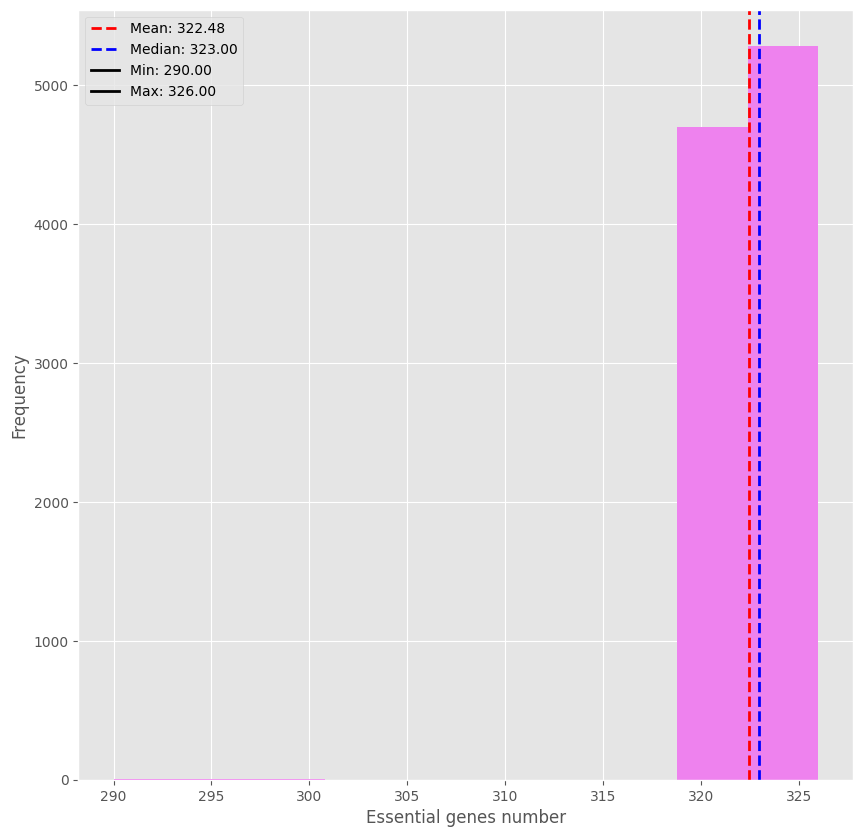

In [69]:
figure_name = "/Users/anastasiiashcherbakova/git_projects/masters_project/figures/essential_genes_9_final_dataset_enhanced.pdf"
plot_color = "violet"

plot_essential_genes_distribution(essential_genes_count_per_sample, figure_name, plot_color)

## 5) Exploring ways to minimise genome size (new loss)

## 5.1) New loss (VAE v1)

just ran a test model with random initial parameters to see how it woudl perform with a new loss (gene abundance) included. L1 regularisation applied to the fetures in the model. one note: the new loss gama and beta params: 
beta_start = 0.1
beta_end = 1.0
gamma_start = 1.0
gamma_end = 0.1

In [70]:
# Load trained model
input_dim = 55039
hidden_dim = 512
latent_dim = 32
path_to_model = "/Users/anastasiiashcherbakova/git_projects/masters_project/genomes/models/saved_8_new_loss_model.pt"

model, binary_generated_samples = load_model(input_dim, hidden_dim, latent_dim, path_to_model)

Generated samples (binary):
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Generated samples (sigmoid function output):
 [[1.56342965e-02 6.93996935e-06 8.27794793e-06 ... 1.29725659e-05
  1.33356589e-05 1.99137066e-05]
 [2.04330627e-02 1.36309163e-05 5.35947765e-05 ... 9.74921204e-05
  9.35605858e-05 1.10108675e-04]
 [1.06665259e-02 8.23705996e-05 9.82533165e-05 ... 4.65636986e-04
  4.76928020e-04 3.20280262e-04]
 ...
 [1.05936677e-04 1.58614595e-04 1.31789502e-05 ... 3.69354930e-05
  3.81173923e-05 4.97333640e-05]
 [1.02116796e-03 4.71882704e-05 1.71865231e-05 ... 1.53524397e-05
  1.63000768e-05 1.36544259e-05]
 [7.76867964e-05 1.39933381e-05 1.79728133e-07 ... 2.38865559e-05
  2.43856011e-05 3.98908014e-05]]


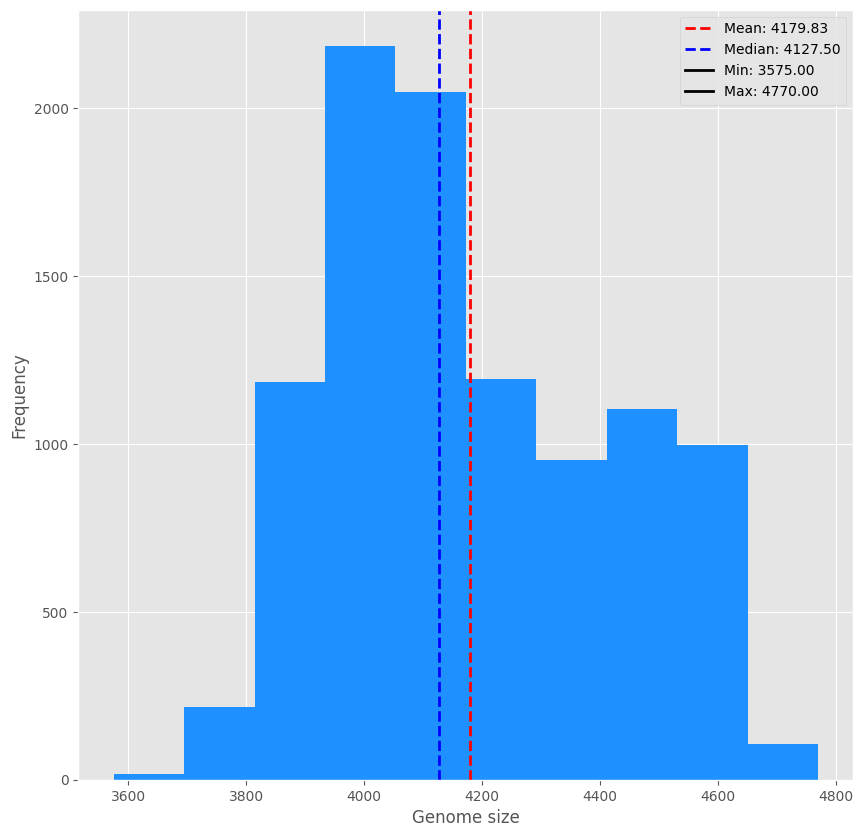

In [71]:
figure_name = "/Users/anastasiiashcherbakova/git_projects/masters_project/figures/sampling_10000_genome_size_distribution_8_new_loss.pdf"
plot_color = "dodgerblue"

plot_samples_distribution(binary_generated_samples, figure_name, plot_color)

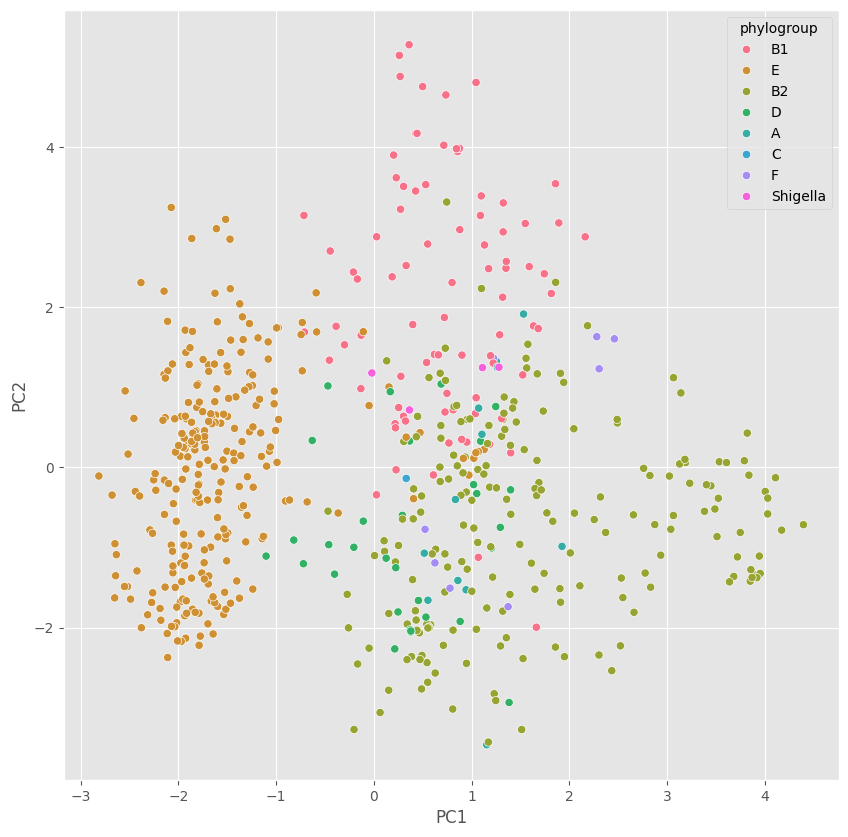

In [72]:
latents = get_latent_variables(model, test_loader, device)
pca = PCA(n_components=2)
data_pca = pca.fit_transform(latents)
df_pca = pd.DataFrame(data_pca, columns=['PC1', 'PC2'])
df_pca['phylogroup'] = test_phylogroups

# Plot the PCA results
plt.figure(figsize=(10, 10))
sns.scatterplot(x='PC1', y='PC2', hue = df_pca['phylogroup'], data=df_pca)
plt.savefig("/Users/anastasiiashcherbakova/git_projects/masters_project/figures/pca_latent_space_visualisation_8_new_loss.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [73]:
essential_genes_count_per_sample = count_essential_genes(binary_generated_samples, essential_gene_positions)

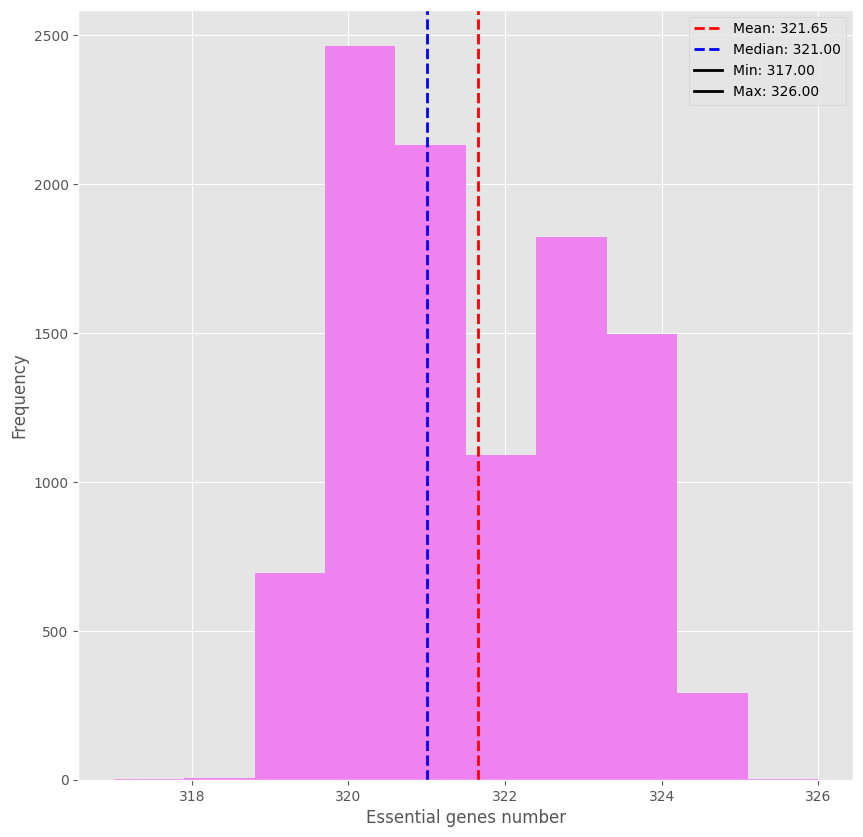

In [74]:
figure_name = "/Users/anastasiiashcherbakova/git_projects/masters_project/figures/essential_genes_8_new_loss.pdf"
plot_color = "violet"

plot_essential_genes_distribution(essential_genes_count_per_sample, figure_name, plot_color)

---------

## 5.1) New loss (VAE v1 but with a dropout layer in decoder)

In [75]:
# Load trained model 
input_dim = 55039
hidden_dim = 512
latent_dim = 32

path_to_model = "/Users/anastasiiashcherbakova/git_projects/masters_project/genomes/models/saved_8_new_loss_enhanced_model.pt"

model, binary_generated_samples = load_model_enhanced(input_dim, hidden_dim, latent_dim, path_to_model)


Generated samples (binary):
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Generated samples (sigmoid function output):
 [[5.01928711e-03 6.50966016e-04 2.18469673e-03 ... 9.55694413e-05
  9.41197723e-05 7.54121356e-05]
 [2.38267588e-03 2.55951290e-05 3.28687020e-04 ... 1.25093284e-05
  1.26747445e-05 9.17104535e-06]
 [3.34122009e-03 4.12276495e-05 1.73357257e-04 ... 3.08336457e-05
  3.14418867e-05 2.76960745e-05]
 ...
 [1.53947594e-02 4.50537009e-05 1.80536741e-03 ... 7.35151698e-05
  7.51929765e-05 6.89160879e-05]
 [3.58398594e-02 1.62108317e-05 1.29549400e-04 ... 1.25243256e-04
  1.23501697e-04 1.63871402e-04]
 [2.81610377e-02 5.58152569e-05 1.40287040e-03 ... 6.08761184e-05
  6.28810449e-05 3.53386531e-05]]


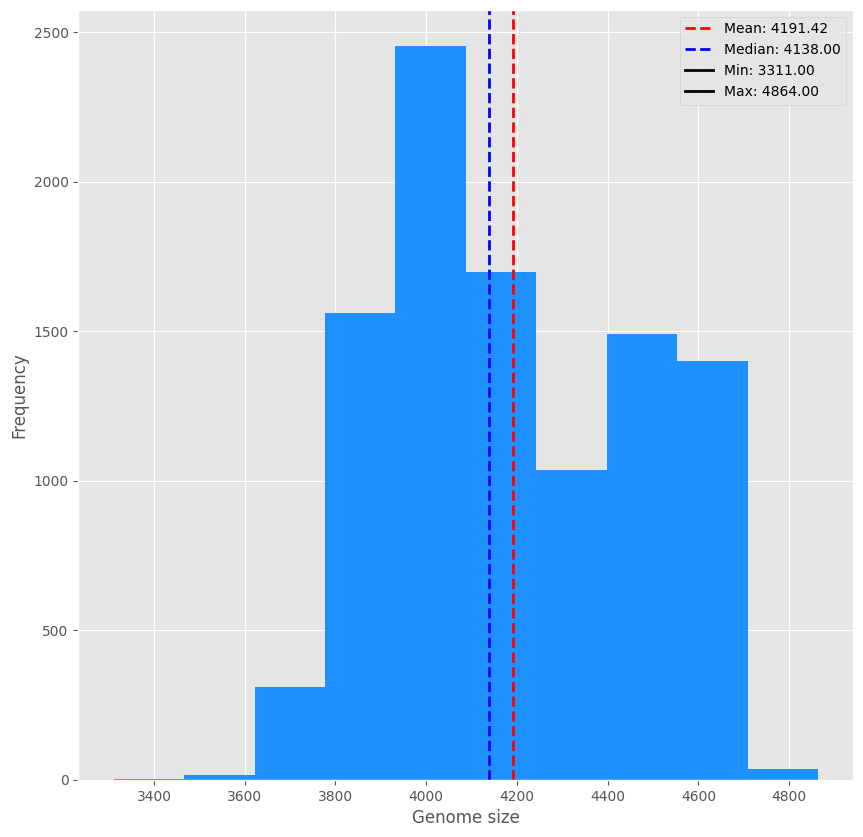

In [76]:
figure_name = "/Users/anastasiiashcherbakova/git_projects/masters_project/figures/sampling_10000_genome_size_distribution_8_new_loss_enhanced_model.pdf"
plot_color = "dodgerblue"

plot_samples_distribution(binary_generated_samples, figure_name, plot_color)

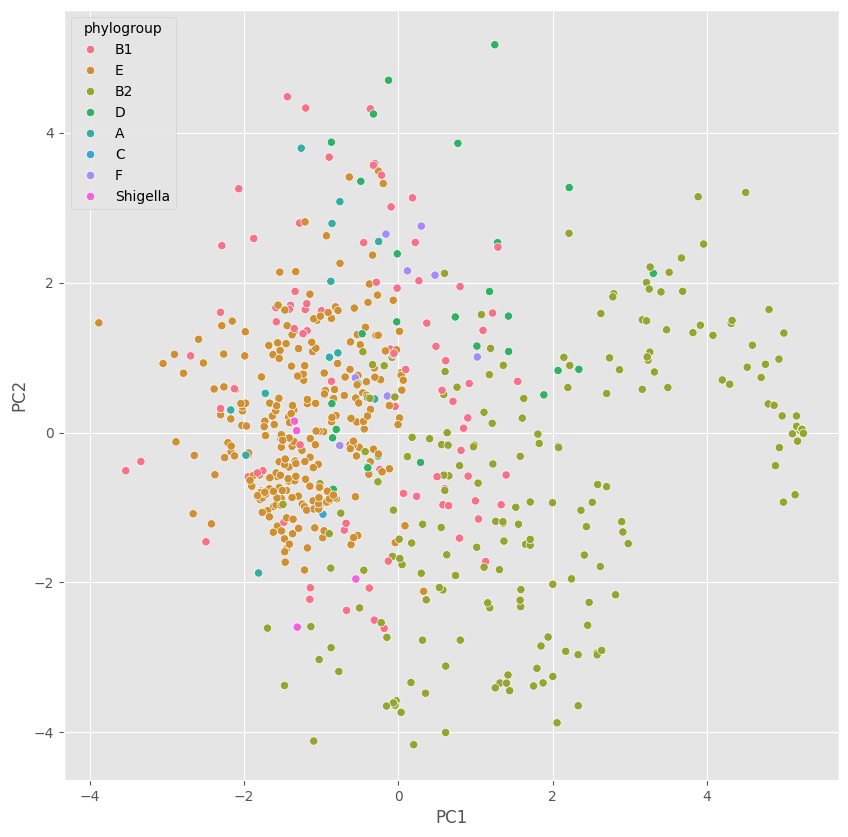

In [77]:
latents = get_latent_variables(model, test_loader, device)
pca = PCA(n_components=2)
data_pca = pca.fit_transform(latents)
df_pca = pd.DataFrame(data_pca, columns=['PC1', 'PC2'])
df_pca['phylogroup'] = test_phylogroups

# Plot the PCA results
plt.figure(figsize=(10, 10))
sns.scatterplot(x='PC1', y='PC2', hue = df_pca['phylogroup'], data=df_pca)
plt.savefig("/Users/anastasiiashcherbakova/git_projects/masters_project/figures/pca_latent_space_visualisation_8_new_loss_enhanced_model.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [78]:
essential_genes_count_per_sample = count_essential_genes(binary_generated_samples, essential_gene_positions)

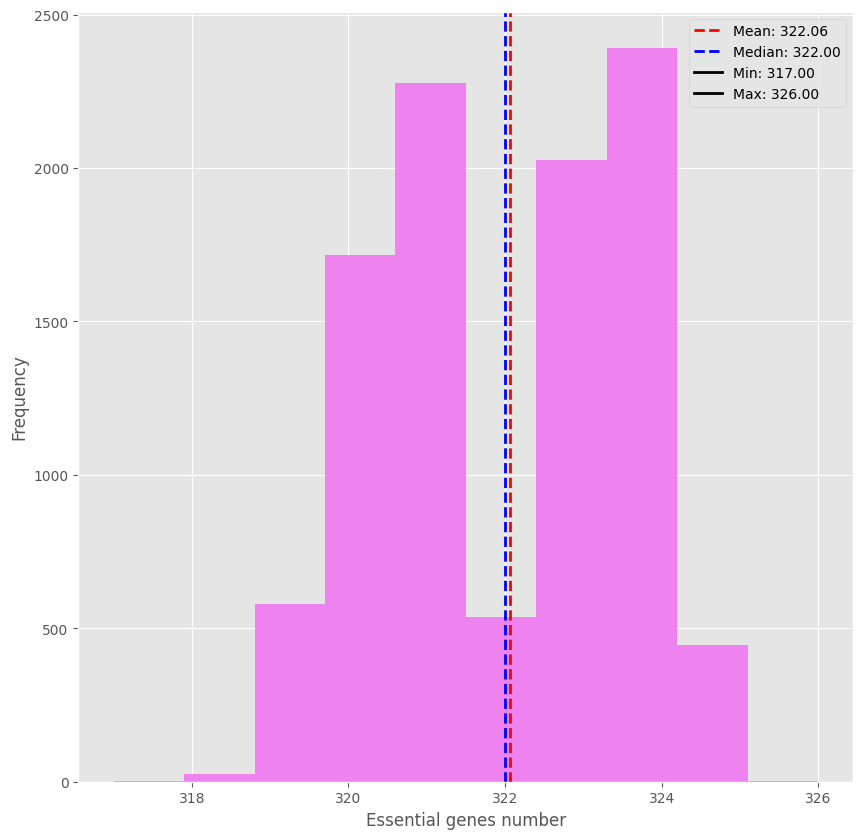

In [79]:
figure_name = "/Users/anastasiiashcherbakova/git_projects/masters_project/figures/essential_genes_8_new_loss_enhanced_model.pdf"
plot_color = "violet"

plot_essential_genes_distribution(essential_genes_count_per_sample, figure_name, plot_color)

------

## 5.1) New loss with no linear annealing (VAE v3)

In [80]:
# Load trained model 
input_dim = 55039
hidden_dim = 512
latent_dim = 32

path_to_model = "/Users/anastasiiashcherbakova/git_projects/masters_project/genomes/models/saved_11_non_linear_annealing_model.pt"

model, binary_generated_samples = load_model(input_dim, hidden_dim, latent_dim, path_to_model)


Generated samples (binary):
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Generated samples (sigmoid function output):
 [[5.64000220e-04 6.46827266e-06 4.88832075e-06 ... 2.75723196e-05
  2.81460052e-05 1.64208705e-05]
 [3.26010763e-06 1.79580347e-05 5.37927417e-06 ... 1.05348969e-04
  1.16659197e-04 8.86602502e-05]
 [1.99710322e-03 3.34986806e-04 3.79653112e-03 ... 1.01253645e-04
  9.77238815e-05 1.28143380e-04]
 ...
 [4.24793288e-02 4.40264967e-06 2.65629442e-05 ... 3.22207125e-05
  3.12103039e-05 2.13588992e-05]
 [3.44175060e-05 1.84750866e-06 4.12288819e-06 ... 2.00595983e-04
  1.88182632e-04 8.40420253e-05]
 [2.14937814e-02 7.18603097e-03 1.20912646e-05 ... 4.49919207e-05
  4.54573892e-05 1.31252555e-05]]


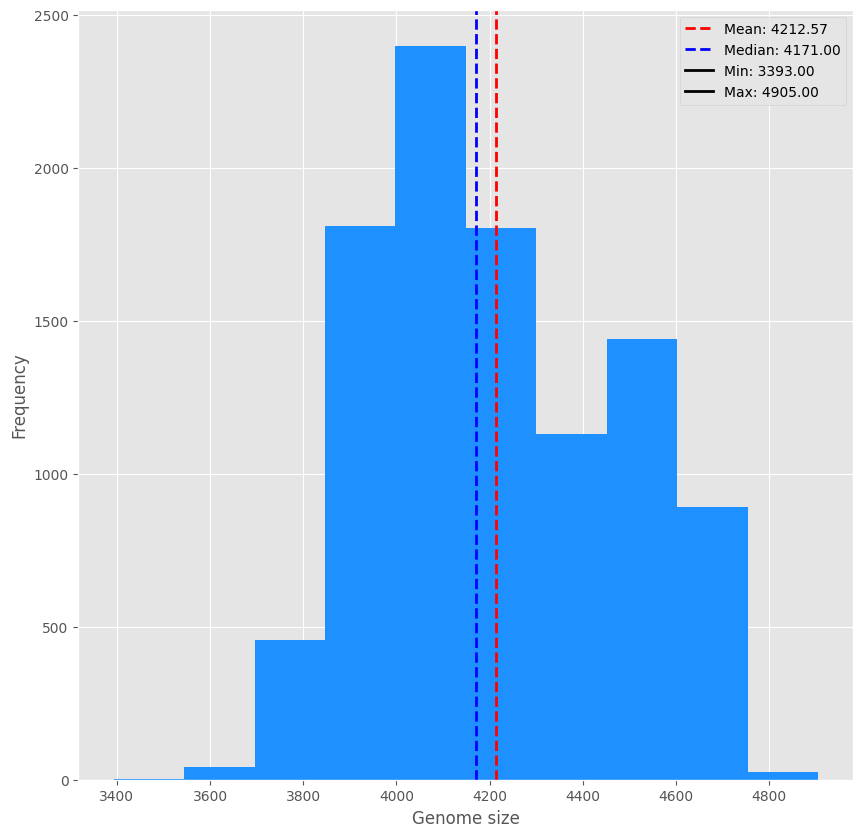

In [81]:
figure_name = "/Users/anastasiiashcherbakova/git_projects/masters_project/figures/sampling_10000_genome_size_distribution_11_non_linear_annealing.pdf"
plot_color = "dodgerblue"

plot_samples_distribution(binary_generated_samples, figure_name, plot_color)

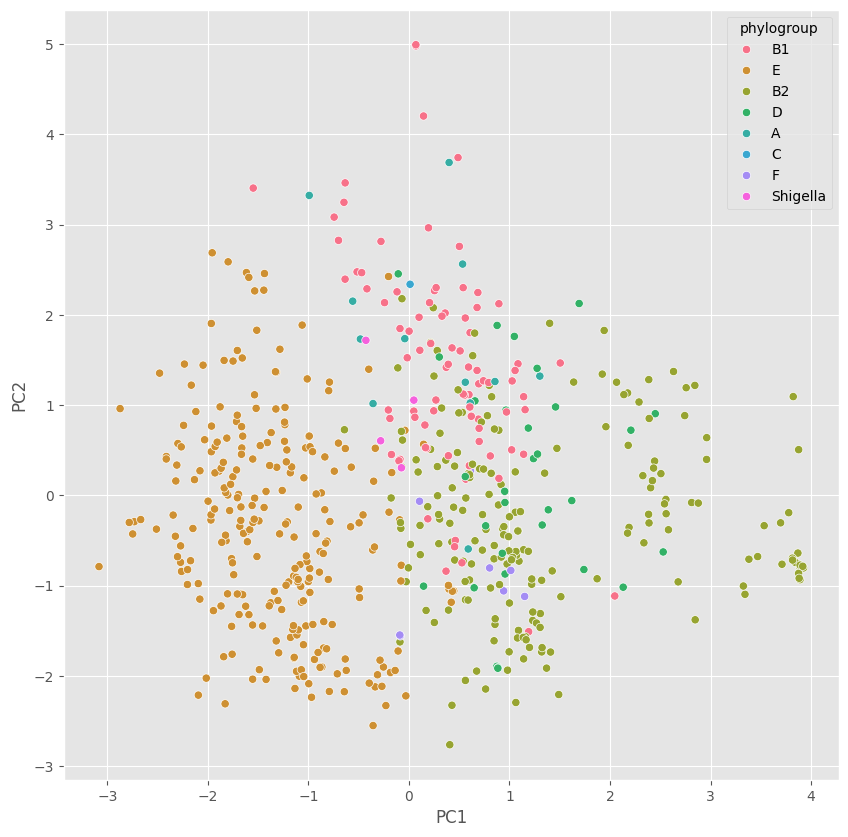

In [82]:
latents = get_latent_variables(model, test_loader, device)
pca = PCA(n_components=2)
data_pca = pca.fit_transform(latents)
df_pca = pd.DataFrame(data_pca, columns=['PC1', 'PC2'])
df_pca['phylogroup'] = test_phylogroups

# Plot the PCA results
plt.figure(figsize=(10, 10))
sns.scatterplot(x='PC1', y='PC2', hue = df_pca['phylogroup'], data=df_pca)
plt.savefig("/Users/anastasiiashcherbakova/git_projects/masters_project/figures/pca_latent_space_visualisation_11_non_linear_annealing.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [83]:
essential_genes_count_per_sample = count_essential_genes(binary_generated_samples, essential_gene_positions)

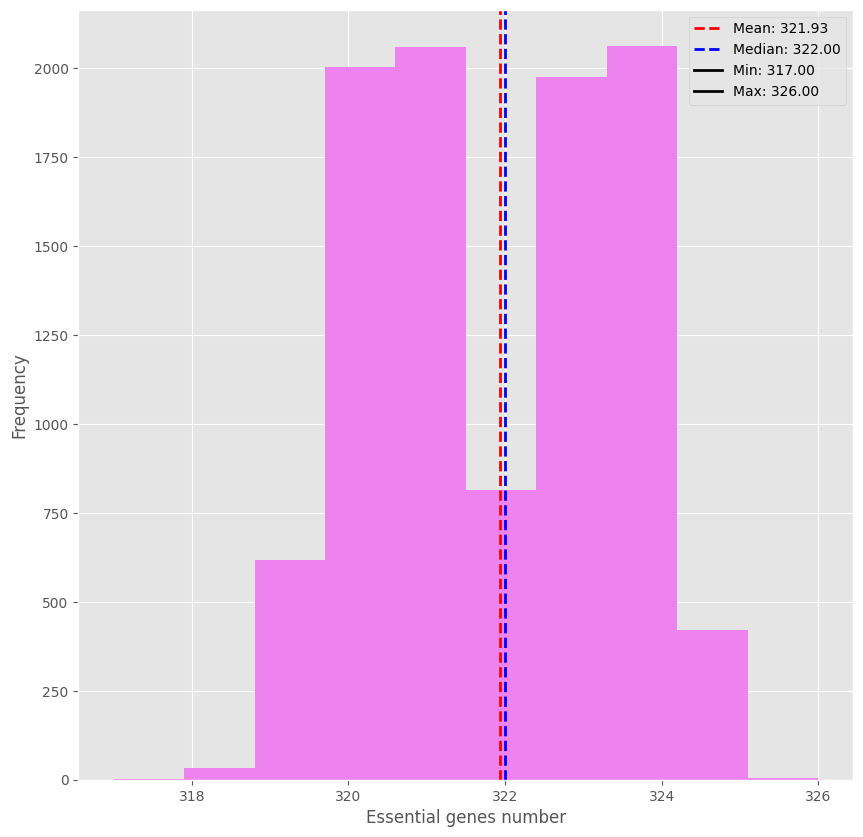

In [84]:
figure_name = "/Users/anastasiiashcherbakova/git_projects/masters_project/figures/essential_genes_11_non_linear_annealing.pdf"
plot_color = "violet"

plot_essential_genes_distribution(essential_genes_count_per_sample, figure_name, plot_color)

_______

## 5.1) New loss with genome size (VAE v2)

In [85]:
# Load trained model 
input_dim = 55039
hidden_dim = 512
latent_dim = 32

path_to_model = "/Users/anastasiiashcherbakova/git_projects/masters_project/genomes/models/saved_13_add_genome_size_model.pt"

model, binary_generated_samples = load_model(input_dim, hidden_dim, latent_dim, path_to_model)


Generated samples (binary):
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Generated samples (sigmoid function output):
 [[8.58969148e-03 4.90184175e-05 1.23485925e-05 ... 2.90327844e-05
  2.96001090e-05 1.50989954e-05]
 [2.50374898e-03 1.44527527e-04 3.57503101e-04 ... 2.76828996e-05
  2.88807132e-05 2.81704961e-05]
 [5.96056925e-04 3.59436002e-04 1.43804746e-05 ... 1.73824610e-05
  1.67923918e-05 2.36567976e-05]
 ...
 [7.15096295e-02 2.69158627e-03 2.51025893e-04 ... 7.64350771e-05
  7.79945476e-05 5.40865440e-05]
 [6.35204924e-05 1.27830950e-04 1.14399290e-05 ... 1.13142421e-04
  1.14508264e-04 9.67170854e-05]
 [9.23942658e-04 4.52506676e-04 1.06780108e-05 ... 6.67435670e-05
  6.73309914e-05 2.68731019e-05]]


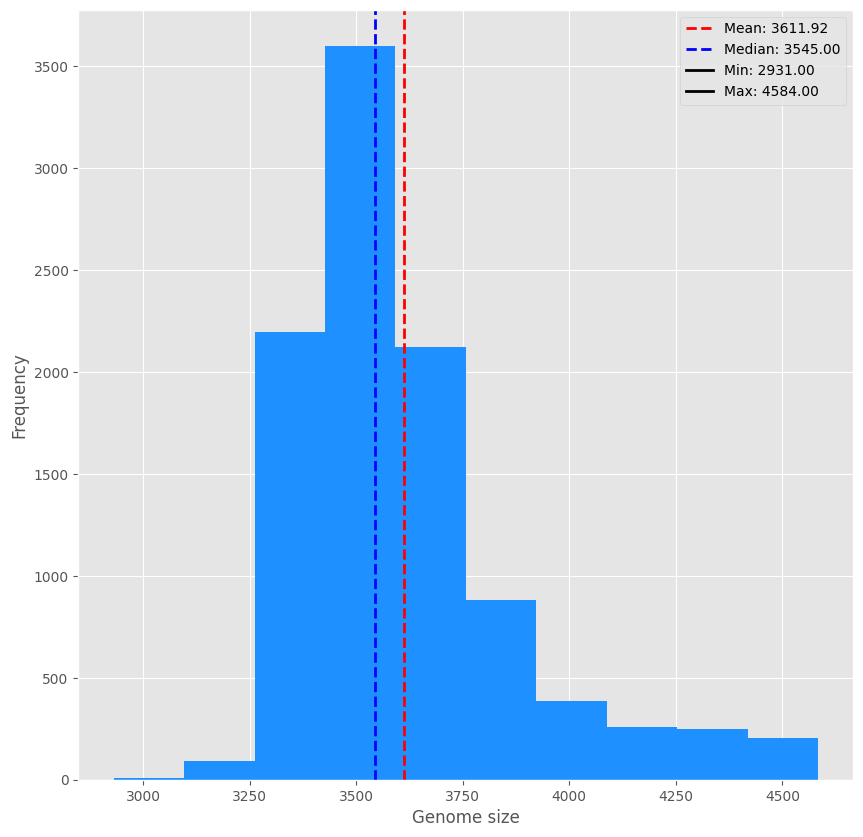

In [86]:
figure_name = "/Users/anastasiiashcherbakova/git_projects/masters_project/figures/sampling_10000_genome_size_distribution_13_add_genome_size.pdf"
plot_color = "dodgerblue"

plot_samples_distribution(binary_generated_samples, figure_name, plot_color)

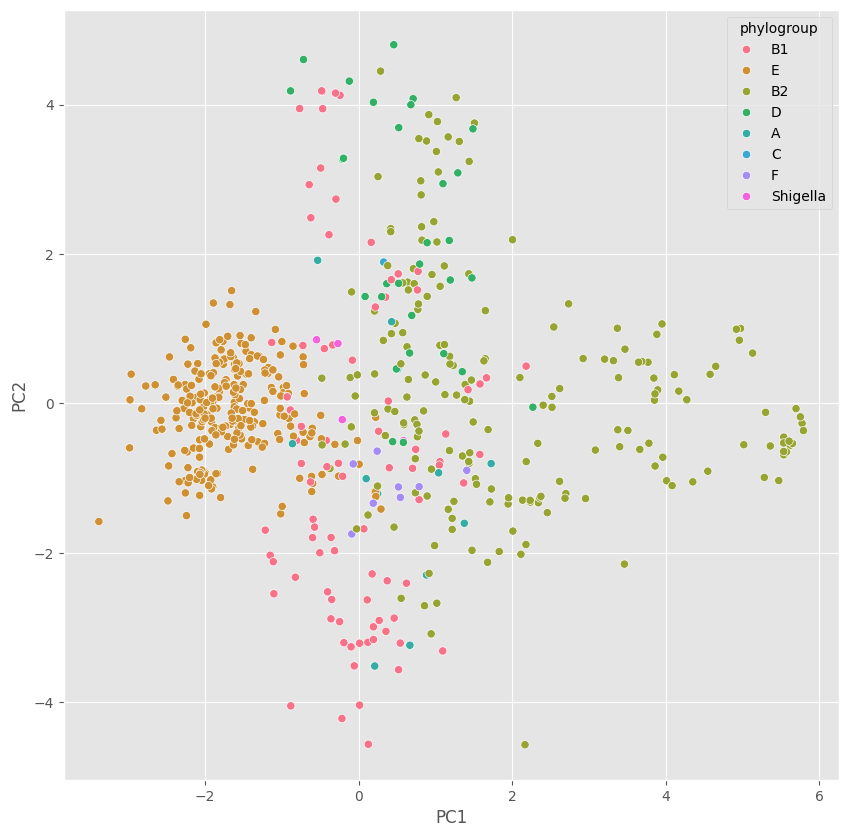

In [87]:
latents = get_latent_variables(model, test_loader, device)
pca = PCA(n_components=2)
data_pca = pca.fit_transform(latents)
df_pca = pd.DataFrame(data_pca, columns=['PC1', 'PC2'])
df_pca['phylogroup'] = test_phylogroups

# Plot the PCA results
plt.figure(figsize=(10, 10))
sns.scatterplot(x='PC1', y='PC2', hue = df_pca['phylogroup'], data=df_pca)
plt.savefig("/Users/anastasiiashcherbakova/git_projects/masters_project/figures/pca_latent_space_visualisation_13_add_genome_size_model.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [88]:
essential_genes_count_per_sample = count_essential_genes(binary_generated_samples, essential_gene_positions)

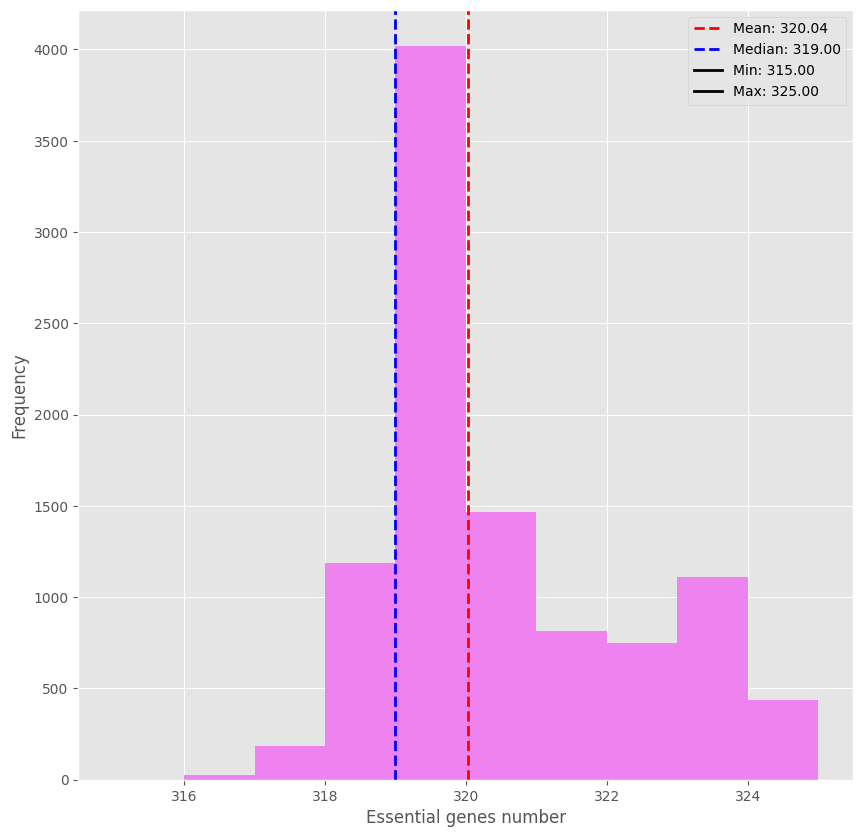

In [89]:
figure_name = "/Users/anastasiiashcherbakova/git_projects/masters_project/figures/essential_genes_13_add_genome_size.pdf"
plot_color = "violet"

plot_essential_genes_distribution(essential_genes_count_per_sample, figure_name, plot_color)

______

## 5.1) New loss with non lenaer annelaing and genome size (VAE v4)

In [90]:
# Load trained model 
input_dim = 55039
hidden_dim = 512
latent_dim = 32

path_to_model = "/Users/anastasiiashcherbakova/git_projects/masters_project/genomes/models/saved_15_genome_size_and_cyclic_annealing_SCALED_model.pt"

model, binary_generated_samples = load_model(input_dim, hidden_dim, latent_dim, path_to_model)


Generated samples (binary):
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Generated samples (sigmoid function output):
 [[4.2369508e-04 8.8189467e-04 3.2996139e-03 ... 1.8217838e-04
  1.8680589e-04 2.2683262e-04]
 [4.4555849e-04 6.0739485e-06 3.4751147e-06 ... 1.4666925e-05
  1.4299693e-05 1.5109050e-05]
 [2.7936460e-03 6.1343913e-04 1.1459711e-03 ... 5.6960253e-05
  5.9251302e-05 5.2040778e-05]
 ...
 [3.7871208e-04 1.7520293e-06 1.3405795e-03 ... 2.4971685e-06
  2.6546168e-06 2.6894711e-06]
 [1.0541448e-05 3.6873134e-06 2.9854648e-06 ... 4.1422369e-05
  4.0520124e-05 3.2247583e-05]
 [6.9597834e-03 1.5678894e-04 1.6350488e-05 ... 2.6668806e-04
  2.6962743e-04 1.1856232e-04]]


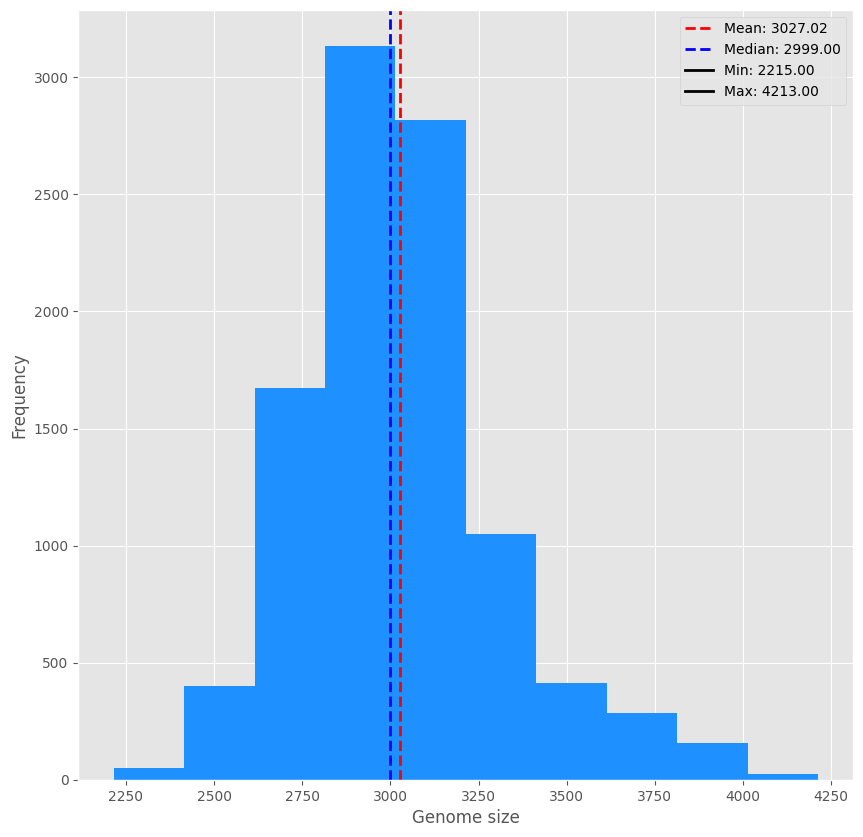

In [91]:
figure_name = "/Users/anastasiiashcherbakova/git_projects/masters_project/figures/sampling_10000_genome_size_distribution_15_genome_size_and_cyclic_annealing_SCALED.pdf"
plot_color = "dodgerblue"

plot_samples_distribution(binary_generated_samples, figure_name, plot_color)

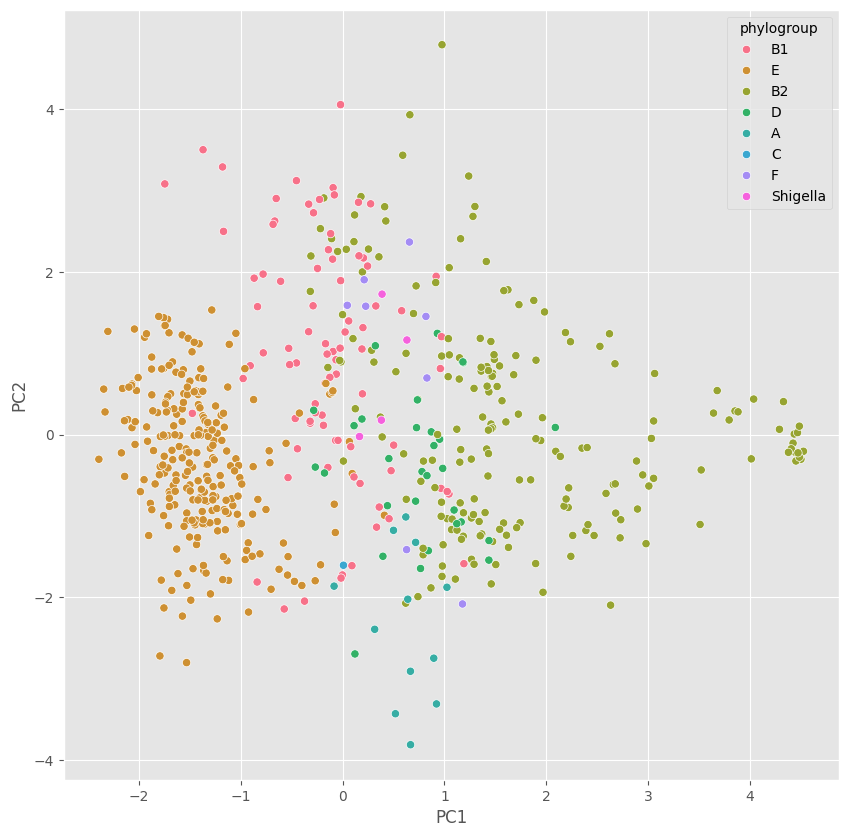

In [92]:
latents = get_latent_variables(model, test_loader, device)
pca = PCA(n_components=2)
data_pca = pca.fit_transform(latents)
df_pca = pd.DataFrame(data_pca, columns=['PC1', 'PC2'])
df_pca['phylogroup'] = test_phylogroups

# Plot the PCA results
plt.figure(figsize=(10, 10))
sns.scatterplot(x='PC1', y='PC2', hue = df_pca['phylogroup'], data=df_pca)
plt.savefig("/Users/anastasiiashcherbakova/git_projects/masters_project/figures/pca_latent_space_visualisation_15_genome_size_and_cyclic_annealing_SCALED.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [93]:
essential_genes_count_per_sample = count_essential_genes(binary_generated_samples, essential_gene_positions)

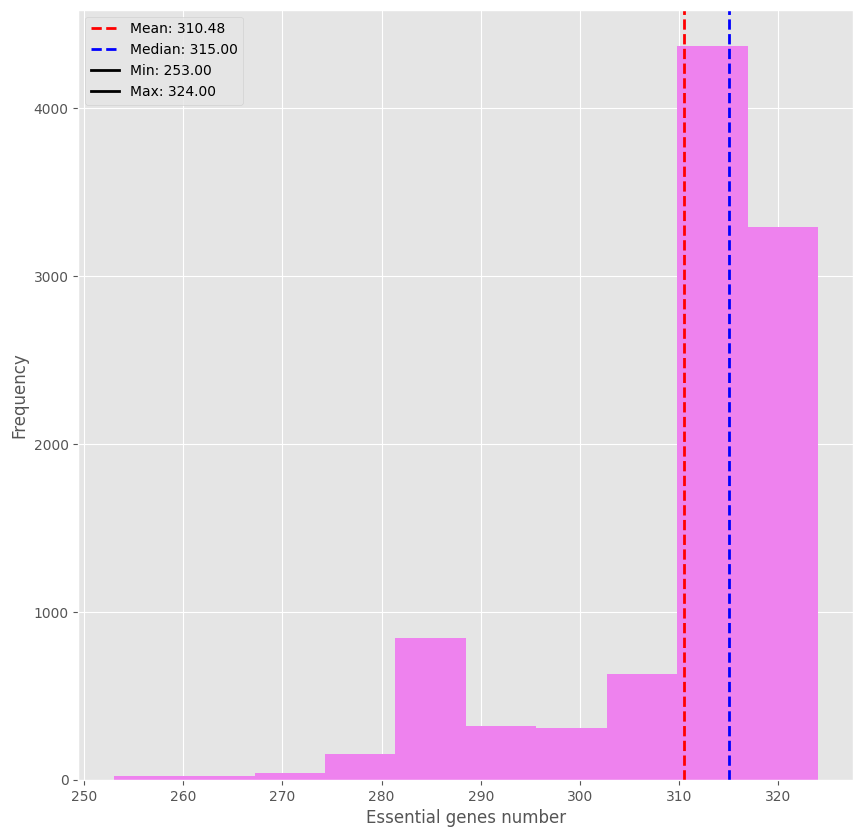

In [94]:
figure_name = "/Users/anastasiiashcherbakova/git_projects/masters_project/figures/essential_genes_15_genome_size_and_cyclic_annealing_SCALED.pdf"
plot_color = "violet"

plot_essential_genes_distribution(essential_genes_count_per_sample, figure_name, plot_color)

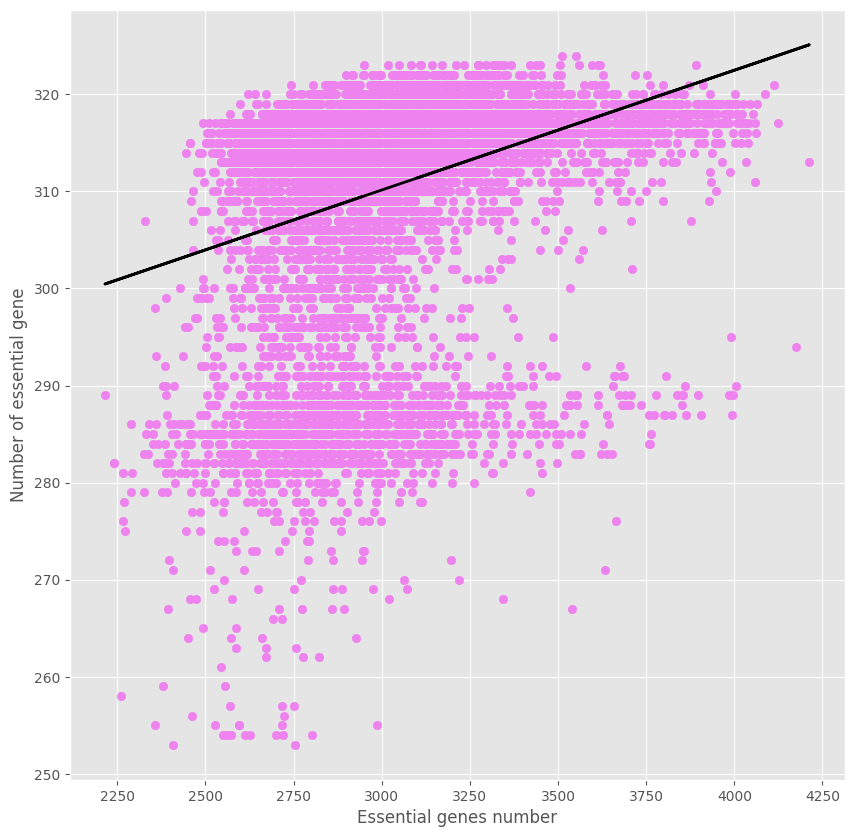

In [95]:
plt.figure(figsize=(10,10))
plt.scatter(binary_generated_samples.sum(axis=1), essential_genes_count_per_sample, color='violet')

coefficients = np.polyfit(binary_generated_samples.sum(axis=1), essential_genes_count_per_sample, 1)
trendline = np.poly1d(coefficients)

plt.plot(binary_generated_samples.sum(axis=1), trendline(binary_generated_samples.sum(axis=1)), color='black', linewidth=2)

plt.xlabel('Essential genes number') 
plt.ylabel('Number of essential gene')

plt.savefig("/Users/anastasiiashcherbakova/git_projects/masters_project/figures/GS_EG_15_genome_size_and_cyclic_annealing_SCALED.pdf", format="pdf", bbox_inches="tight")

In [96]:
num_samples = 10000
with torch.no_grad():
    z = torch.randn(num_samples, latent_dim)  # Sample from the standard normal distribution because the latent space follows normal distribution 
    generated_samples = model.decode(z).cpu().numpy() 

threshold = 0.5
binary_generated_samples = (generated_samples > threshold).astype(float)

print("Generated samples (binary):\n", binary_generated_samples)
print("\n")
print("Generated samples (sigmoid function output):\n", generated_samples)

Generated samples (binary):
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Generated samples (sigmoid function output):
 [[1.38242636e-02 2.70273613e-05 1.34237390e-03 ... 1.61141201e-04
  1.59724630e-04 1.55884380e-04]
 [8.80834684e-02 9.21902938e-06 8.58360909e-06 ... 1.52524983e-04
  1.49938161e-04 1.14294235e-04]
 [1.17556797e-02 2.01639166e-04 6.59617130e-04 ... 8.76981539e-06
  8.62131401e-06 1.56077986e-05]
 ...
 [6.66851737e-03 1.24802624e-04 8.07874021e-05 ... 4.35479233e-05
  4.54322580e-05 6.50127258e-05]
 [3.60746402e-03 1.35924836e-06 7.78950198e-05 ... 2.35610205e-05
  2.35304360e-05 3.16391415e-05]
 [3.34024051e-04 1.07232347e-06 1.41605260e-05 ... 7.66547691e-06
  7.45024090e-06 7.43838518e-06]]


In [97]:
total_ones = np.sum(binary_generated_samples, axis=1)
min_ones_index = np.argmin(total_ones)

latent_distances = np.linalg.norm(generated_samples - generated_samples[min_ones_index], axis=1)

closest_latent_index = np.argmin(latent_distances)

print(f"Closest latent vector (z): {z[closest_latent_index]}")
print(f"Generated sample from closest latent vector:\n {generated_samples[closest_latent_index]}")

Closest latent vector (z): tensor([-0.4803, -0.1820, -1.9069, -0.1870,  0.7424, -1.4761,  2.0518,  0.4117,
         1.1977,  0.7329,  1.0853,  0.4369,  0.4753,  0.1396, -0.0284, -0.0967,
         0.8577,  1.1952,  0.3818,  0.5751,  3.1460, -1.3473,  0.2270,  1.2215,
         1.9165,  0.6789, -0.4649, -1.4154,  0.6789, -0.5618, -0.5918,  1.8337])
Generated sample from closest latent vector:
 [1.7589235e-05 2.0084613e-05 3.4407071e-06 ... 1.0137811e-03 9.6726289e-04
 6.9773215e-04]


In [98]:
sum(binary_generated_samples[min_ones_index])

2133.0

Sampling additional samples from the minimal genomes region

In [99]:
z_of_interest = z[closest_latent_index] 
z_of_interest_tensor = torch.tensor(z_of_interest).unsqueeze(0)  

noise_std = 0.1

num_additional_samples = 10000  
with torch.no_grad():
    noise = torch.randn(num_additional_samples, latent_dim) * noise_std
    z_samples = z_of_interest_tensor + noise
    additional_generated_samples = model.decode(z_samples).cpu().numpy()


print("Additional generated samples:")
print(additional_generated_samples)

/var/folders/nx/hnfjrvz145n2_hzn95z65pmc0000gn/T/ipykernel_93160/2647228576.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_of_interest_tensor = torch.tensor(z_of_interest).unsqueeze(0)


Additional generated samples:
[[1.1886022e-05 2.3431261e-05 2.4315457e-06 ... 1.1097731e-03
  1.0639800e-03 7.2332495e-04]
 [3.0405923e-05 2.6647940e-05 2.5182087e-06 ... 9.6019875e-04
  9.1722218e-04 6.7174440e-04]
 [2.0878404e-05 1.9297320e-05 3.0317269e-06 ... 1.0953236e-03
  1.0436445e-03 7.7215035e-04]
 ...
 [1.1978798e-05 1.0994052e-05 3.8921021e-06 ... 8.2023727e-04
  7.8674481e-04 5.5243389e-04]
 [1.5557511e-05 1.6176748e-05 2.4078975e-06 ... 1.2845644e-03
  1.2252815e-03 8.3987677e-04]
 [2.0946070e-05 1.6437461e-05 2.0992670e-06 ... 1.1419174e-03
  1.0824709e-03 7.3811406e-04]]


In [100]:
threshold = 0.5
additional_generated_samples = (additional_generated_samples > threshold).astype(float)

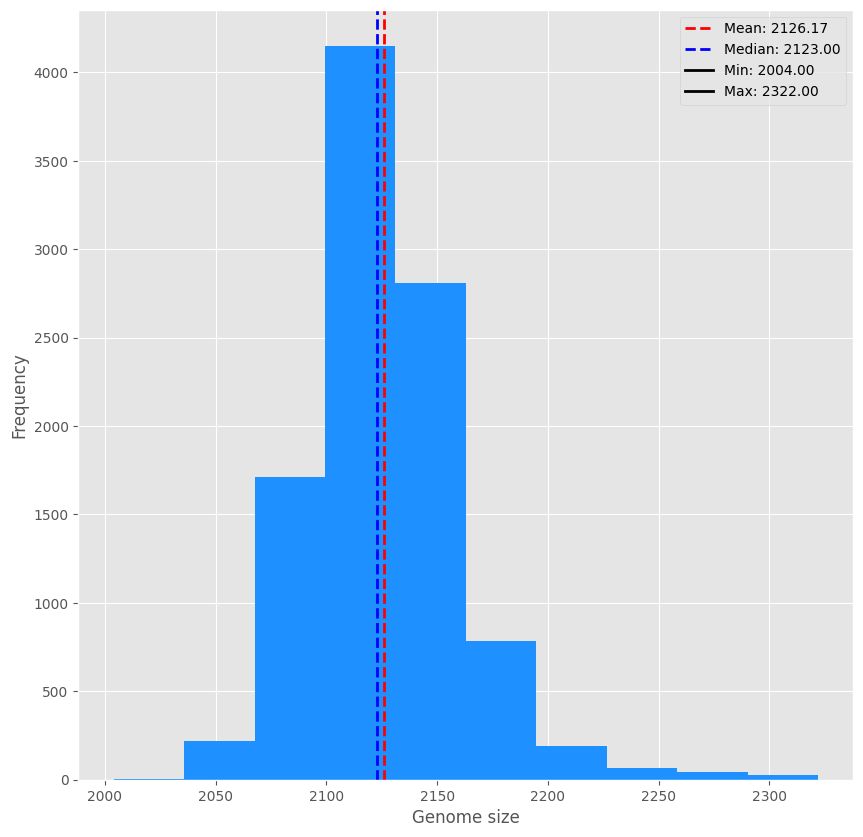

In [101]:
figure_name = "/Users/anastasiiashcherbakova/git_projects/masters_project/figures/additional_sampling_10000_genome_size_distribution_15_genome_size_and_cyclic_annealing_SCALED.pdf"
plot_color = "dodgerblue"

plot_samples_distribution(additional_generated_samples, figure_name, plot_color)


In [102]:
np.save('/Users/anastasiiashcherbakova/git_projects/masters_project/data/additional_generated_samples.npy', additional_generated_samples)

In [103]:
essential_genes_count_per_sample = count_essential_genes(additional_generated_samples, essential_gene_positions)

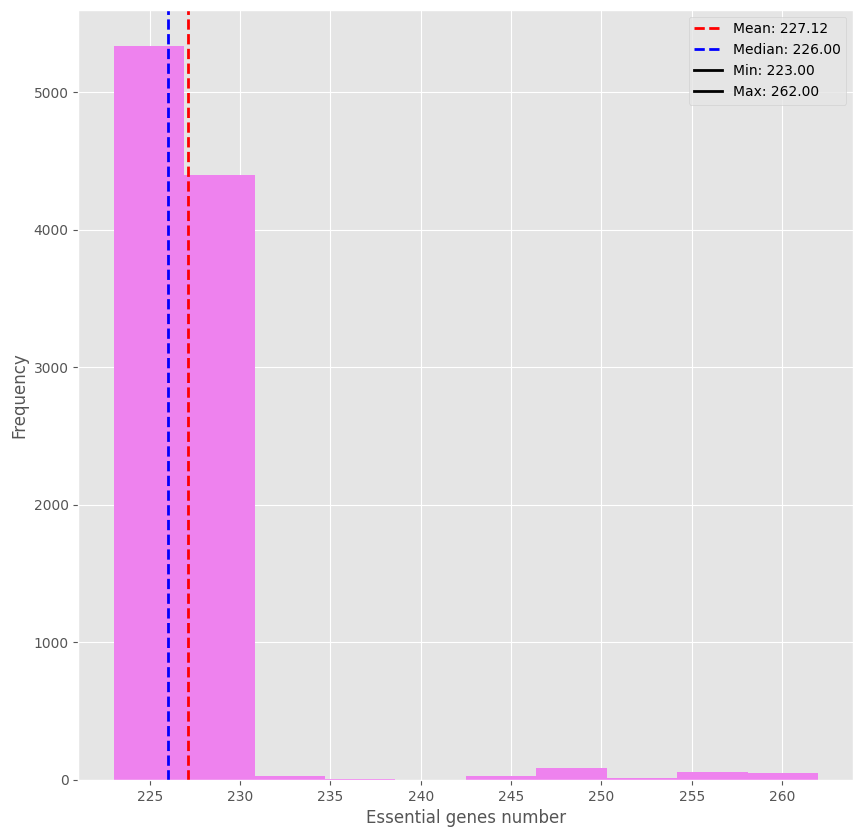

In [104]:
figure_name = "/Users/anastasiiashcherbakova/git_projects/masters_project/figures/additioinal_essential_genes_15_genome_size_and_cyclic_annealing_SCALED.pdf"
plot_color = "violet"

plot_essential_genes_distribution(essential_genes_count_per_sample, figure_name, plot_color)

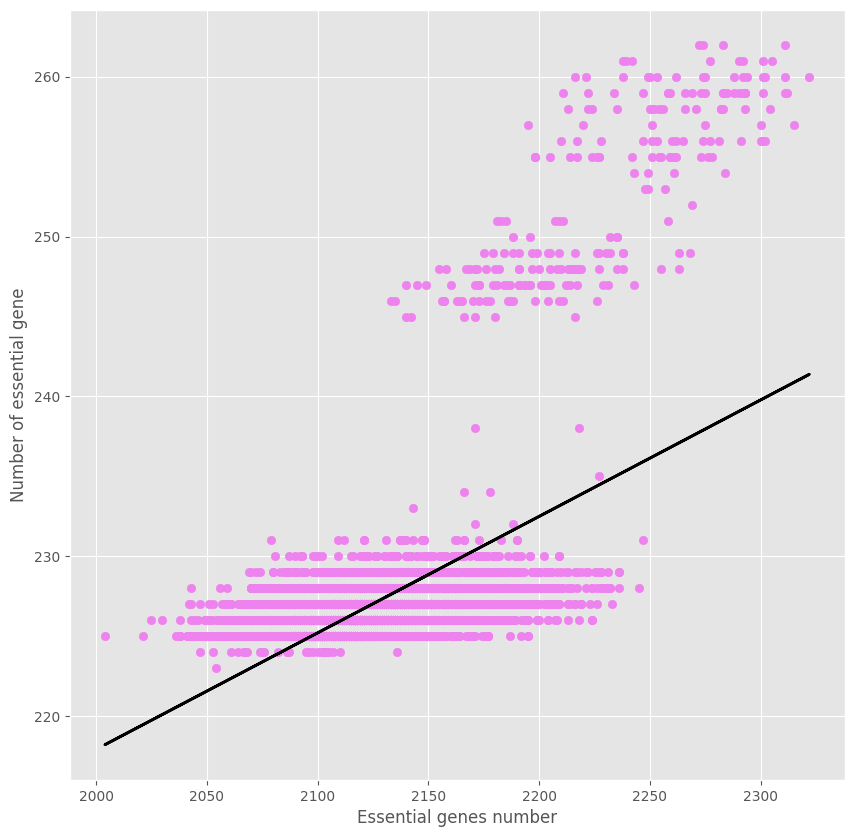

In [105]:
plt.figure(figsize=(10,10))
plt.scatter(additional_generated_samples.sum(axis=1), essential_genes_count_per_sample, color='violet')

coefficients = np.polyfit(additional_generated_samples.sum(axis=1), essential_genes_count_per_sample, 1)
trendline = np.poly1d(coefficients)

plt.plot(additional_generated_samples.sum(axis=1), trendline(additional_generated_samples.sum(axis=1)), color='black', linewidth=2)

plt.xlabel('Essential genes number') 
plt.ylabel('Number of essential gene')

plt.savefig("/Users/anastasiiashcherbakova/git_projects/masters_project/figures/additional_GS_EG_15_genome_size_and_cyclic_annealing_SCALED.pdf", format="pdf", bbox_inches="tight")

---------

# 6) Creating lists of lists with all genes in the sampled genomes

In [106]:
def extract_prefix(gene):
    match = re.match(r"([a-zA-Z0-9]+)", gene)
    if match:
        return match.group(1)
    return gene

# Step 1: Get the top 100 essential gene counts
top_100_values = np.sort(essential_genes_count_per_sample)[-100:][::-1]

# Step 2: Find the sequence indices in the array
sequence_indices = []
for value in top_100_values:
    indices = np.where(essential_genes_count_per_sample == value)[0]
    sequence_indices.extend(indices)

# Ensure we only get the first 100 unique indices in case of duplicates
sequence_indices = sequence_indices[:100]

# Step 3: Get the samples from additional_generated_samples
samples = additional_generated_samples[sequence_indices]

# Step 4: Find what genes they have present
present_genes_lists = []
for sample in samples:
    present_genes = all_genes[:-1][sample == 1]
    present_genes_lists.append(present_genes)

# Step 5: Clean up the gene names and add essential genes
cleaned_genes_lists = []
for genes in present_genes_lists:
    cleaned_gene_names = [extract_prefix(name) for name in genes]
    cleaned_gene_names.extend(datatset_EG) 
    cleaned_genes_lists.append(cleaned_gene_names)

np.save('/Users/anastasiiashcherbakova/git_projects/masters_project/data/cleaned_genes_lists.npy', np.array(cleaned_genes_lists, dtype=object))

In [107]:
top_100_values

array([262, 262, 262, 262, 261, 261, 261, 261, 261, 261, 261, 261, 260,
       260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260,
       260, 260, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259,
       259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 258,
       258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258,
       258, 258, 257, 257, 257, 257, 257, 257, 256, 256, 256, 256, 256,
       256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 255, 255,
       255, 255, 255, 255, 255, 255, 255, 255, 255])

---------

# (EXTRA) 7) Comparing the two different essential genes arrays

This step was done early on, however, we also compared the number of essential genes in on this website (https://shigen.nig.ac.jp/ecoli/pec/) with the essnetial genes in the dataset and we figures out we shoudl use Goodall et. al. essential genes

In [108]:
file_path = '/Users/anastasiiashcherbakova/git_projects/masters_project/data/essential_genes_website.txt'

df = pd.read_csv(file_path, delimiter='\t')  

df.to_csv('/Users/anastasiiashcherbakova/git_projects/masters_project/data/essential_genes_website.csv', index=False)

essential_genes_website = pd.read_csv('/Users/anastasiiashcherbakova/git_projects/masters_project/data/essential_genes_website.csv')

In [109]:
essential_genes_website_array = np.array(essential_genes_website['Gene Name'])

In [110]:
essential_genes_mask = np.isin(all_genes, essential_genes_website_array)
essential_genes_df = merged_df.loc[:, essential_genes_mask].copy()

In [111]:
essential_genes_df

,holB,secD,coaE,can,folK,hemL,erpA,dapD,map,rpsB,...,mrdB,mrdA,nadD,holA,lptE,leuS,lnt,glnS,fldA,hemB
ID,,,,,,,,,,,,,,,,,,,,,
AIAW00000000,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
AIBY00000000,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
AIFN00000000,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
NC_002655,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
NC_002695,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ESC_PA2021AA_AS,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
ESC_PA2023AA_AS,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
ESC_PA2315AA_AS,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [112]:
essential_genes_present_array = np.array(essential_genes_df.columns)
print(f"Essential genes present in the dataset: {len(essential_genes_present_array)}")

Essential genes present in the dataset: 274


In [113]:
genes_missing = list(set(essential_genes_website_array) - set(essential_genes_present_array))

In [114]:
print(f"Missing genes: {len(genes_missing)}")

Missing genes: 28


In [115]:
matched_columns = []

for gene in genes_missing:
    pattern = re.compile(f"{gene}")
    matches = [col for col in merged_df.columns if pattern.match(col) and col not in present_genes]
    matched_columns.extend(matches)


divided_genes = np.array(matched_columns)
print(divided_genes)
print(len(divided_genes))


['topA_3' 'topA_3_1' 'topA_3_2' 'fbaA_1' 'fbaA_3' 'fbaA_3_1' 'fbaA_1_1'
 'fabG_3' 'fabG_1_1' 'fabG_2_1' 'fabG_4' 'fabG_4_1' 'fabG_2_2' 'fabG2'
 'fabG_2_3' 'lolD_3' 'lolD_3_1' 'lolD_4' 'ssbA' 'ssb_1' 'ssb_1_1' 'ssb_2'
 'ssb_4' 'ssb_2_1' 'ssb_2_2' 'ssb_1_2' 'ssb_1_3' 'ssb_5' 'ssbA_1' 'msbA_3'
 'lptG_1' 'lptG_2' 'lptG_3' 'lptG_2_1' 'lptG_1_1' 'dnaC_3' 'dnaC_1'
 'dnaC_2' 'dnaC_1_1' 'dnaC_1_2' 'dnaC_1_3' 'dnaC_1_4' 'dnaC_1_5'
 'dnaC_2_1' 'dnaC_1_6' 'dnaC_2_2' 'metG_2_1' 'metG_2_2']
48


In [116]:
missing_genes = ['ssb', 'dnaC', 'metG', 'fabG', 'lptB', 'msbA', 'fbaA', 'lolD', 'topA', 'lptG'] 

In [117]:
# Find the values that are only in essential genes form the website
unique_in_array1 = np.setdiff1d(essential_genes_website_array, essential_genes_array)

# Find the values that are only in essential genes form the paper
unique_in_array2 = np.setdiff1d(essential_genes_array, essential_genes_website_array)

print("Values only in website array:", unique_in_array1)
print("Values only in paper array:", unique_in_array2)

Values only in website array: ['argU' 'argX' 'cysT' 'degS' 'efp' 'ffs' 'folK' 'ftsE' 'ftsK' 'ftsN'
 'ftsX' 'glyT' 'hisR' 'kdsC' 'leuU' 'leuW' 'leuZ' 'lptC' 'polA' 'priA'
 'proM' 'ribB' 'rne' 'rnpB' 'rseP' 'secD' 'secF' 'secM' 'serT' 'serV'
 'spoT' 'thrU' 'trpT' 'yceQ' 'yejM']
Values only in paper array: ['aceF' 'cohE' 'cydA' 'cydB' 'cydC' 'cydD' 'cydX' 'dapF' 'dcd' 'dicA'
 'fabH' 'fdx' 'folP' 'glyA' 'guaA' 'hemE' 'higA' 'hipB' 'holD' 'hscA'
 'ihfA' 'iraM' 'iscS' 'iscU' 'lipA' 'lpd' 'lpxL' 'lysS' 'pdxH' 'pheM'
 'priB' 'ptsI' 'purB' 'racR' 'rbfA' 'relB' 'rimM' 'rluD' 'rnt' 'rpe'
 'rplA' 'rplK' 'rplY' 'rpmF' 'rpmI' 'rpoE' 'rpsF' 'rpsO' 'rpsT' 'rpsU'
 'safA' 'sucA' 'sucB' 'tadA' 'thyA' 'tktA' 'tonB' 'trpL' 'ttcC' 'tusE'
 'ubiB' 'ubiD' 'ubiE' 'ubiG' 'ubiH' 'ubiX' 'wzyE' 'ybeY' 'ycaR' 'yciS'
 'ydaE' 'ydaS' 'ydcD' 'yddL' 'ydfO' 'ydhL' 'yedN' 'yffS' 'ygeF' 'ygeG'
 'ygeN' 'ygfZ' 'yjbS' 'ykfM' 'ymfE' 'ymiB' 'ynbG' 'yncH' 'yobI' 'yqcG'
 'yqeL']
